# ÏòÅÏóÖ ÏÑ±Í≥µ Ïó¨Î∂Ä Î∂ÑÎ•ò Í≤ΩÏßÑÎåÄÌöå

# 0. ‚≠ï ÌïÑÏàò ÎùºÏù¥Î∏åÎü¨Î¶¨

In [ ]:
!pip install catboost
!pip install ipywidgets
import ipywidgets as widgets
widgets.IntSlider()

IntSlider(value=0)

In [ ]:
# ÏÇ¨Ïö© ÎùºÏù¥Î∏åÎü¨Î¶¨
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.utils.class_weight import compute_class_weight # Í∞ÄÏ§ëÏπò Î∂ÄÏó¨

import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve, auc

#Î™®Îç∏ ÎùºÏù¥Î∏åÎü¨Î¶¨
from catboost import CatBoostClassifier, Pool

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Îç∞Ïù¥ÌÑ∞ ÏÖã ÏùΩÏñ¥Ïò§Í∏∞

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/LG Hackerton/train.csv") # ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞
df_test = pd.read_csv("/content/drive/MyDrive/LG Hackerton/submission.csv") # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞(Ï†úÏ∂úÌååÏùºÏùò Îç∞Ïù¥ÌÑ∞)

# submission Ï†úÏ∂úÌïòÎ©¥ÏÑú Ï†ÄÏû•Îêú Ïó¥ ÏÇ≠Ï†ú
if 'is_converted' in df_test.columns:
    df_test.drop(['is_converted'], axis=1, inplace=True)

# 1. ‚≠ï EDA

In [ ]:
# train data Ïª¨Îüº Î≥Ñ Ïú†Ìòï ÌôïÏù∏
print('df_train information')
print(df_train.info())
print()

# test data Ïª¨Îüº Î≥Ñ Ïú†Ìòï ÌôïÏù∏
print('df_test information')
print(df_test.info())

df_train information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  p

In [ ]:
# Í∏∞Î≥∏Ï†ÅÏù∏ Ï†ÑÏ≤òÎ¶¨ÏôÄ EDAÎ•º ÏßÑÌñâÌïòÍ∏∞ ÏúÑÌï¥ train dataÏôÄ test dataÎ•º Ìï©ÏπòÍ≥†, Ïù¥Î•º Íµ¨Î∂ÑÌï† Ïàò ÏûàÎèÑÎ°ù index Ï†ÄÏû•
data = pd.concat([df_train,df_test])
data.index = range(len(data))
train_index = range(len(df_train))
test_index = range(len(df_train),len(data))

# ÏàòÏπòÌòï Ïª¨ÎüºÍ≥º Î≤îÏ£ºÌòï Ïª¨Îüº Íµ¨Î∂Ñ (id ÏôÄ, Target columns Ï†úÏô∏)
numeric_columns = list(data.drop(['id','is_converted'],axis=1).select_dtypes(include='number').columns)
categorical_columns = list(data.drop(['id','is_converted'],axis=1).columns.difference(numeric_columns))

# Feature Ïª¨ÎüºÍ≥º Target Ïª¨Îüº Î∂ÑÌï† (Î™®Îç∏ ÌïôÏäµÏãúÏóê idÎäî ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏùå)
feature_columns = list(data.drop(['id','is_converted'],axis=1).columns)
target_columns = ['is_converted']

### 1-1. Îç∞Ïù¥ÌÑ∞Ïùò ÌòïÌÉú **ÌôïÏù∏**

In [ ]:
# Îç∞Ïù¥ÌÑ∞Ïùò ÌòïÌÉú ÌôïÏù∏
print('train dataÏùò Îç∞Ïù¥ÌÑ∞ Ïàò: %d, train dataÏùò Ïª¨Îüº Ïàò: %d' %(len(data.loc[train_index,:]),len(data.loc[train_index,:].columns)-1))
print('test dataÏùò Îç∞Ïù¥ÌÑ∞ Ïàò: %d, test dataÏùò Ïª¨Îüº Ïàò: %d' %(len(data.loc[test_index,:]),len(data.loc[test_index,:].columns)))

train dataÏùò Îç∞Ïù¥ÌÑ∞ Ïàò: 59299, train dataÏùò Ïª¨Îüº Ïàò: 29
test dataÏùò Îç∞Ïù¥ÌÑ∞ Ïàò: 5271, test dataÏùò Ïª¨Îüº Ïàò: 30


In [ ]:
data.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_country.1', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area',
       'business_subarea', 'lead_owner', 'is_converted', 'id'],
      dtype='object')

In [ ]:
# ÏàòÏπòÌòï Îç∞Ïù¥ÌÑ∞ Ïª¨Îüº Î≥Ñ ÌÜµÍ≥ÑÍ∞í ÌôïÏù∏
data.describe()

bant_submit  com_reg_ver_win_rate  customer_idx  \
count  64570.000000          16356.000000  64570.000000   
mean       0.632236              0.092849  26914.552315   
std        0.293474              0.151108  14666.049872   
min        0.000000              0.003788      1.000000   
25%        0.500000              0.024432  14614.250000   
50%        0.500000              0.049180  26527.000000   
75%        1.000000              0.074949  40177.250000   
max        1.000000              1.000000  47466.000000   

       historical_existing_cnt  id_strategic_ver  it_strategic_ver  \
count             15031.000000            4037.0            1174.0   
mean                 20.027610               1.0               1.0   
std                  48.039031               0.0               0.0   
min                   0.000000               1.0               1.0   
25%                   1.000000               1.0               1.0   
50%                   4.000000               1.0               1.0   
75%                  19.000000               1.0               1.0   
max                2219.000000               1.0               1.0   

       idit_strategic_ver  lead_desc_length       ver_cus       ver_pro  \
count              5211.0      64570.000000  64570.000000  64570.000000   
mean                  1.0         79.479309      0.050194      0.053306   
std                   0.0        132.758693      0.218346      0.224646   
min                   1.0          1.000000      0.000000      0.000000   
25%                   1.0          7.000000      0.000000      0.000000   
50%                   1.0         29.000000      0.000000      0.000000   
75%                   1.0         93.000000      0.000000      0.000000   
max                   1.0       1264.000000      1.000000      1.000000   

       ver_win_rate_x  ver_win_ratio_per_bu    lead_owner            id  
count    20790.000000          17210.000000  64570.000000   5271.000000  
mean         0.001114              0.050296    265.983862  10686.395940  
std          0.001114              0.029054    232.710329   6141.012698  
min          0.000002              0.011583      0.000000      1.000000  
25%          0.000298              0.026846     97.000000   5644.000000  
50%          0.000572              0.049840    175.000000  10067.000000  
75%          0.001183              0.064566    375.000000  16019.500000  
max          0.003079              0.285714   1114.000000  21340.000000

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64570 entries, 0 to 64569
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              64570 non-null  float64
 1   customer_country         63588 non-null  object 
 2   business_unit            64570 non-null  object 
 3   com_reg_ver_win_rate     16356 non-null  float64
 4   customer_idx             64570 non-null  int64  
 5   customer_type            19152 non-null  object 
 6   enterprise               64570 non-null  object 
 7   historical_existing_cnt  15031 non-null  float64
 8   id_strategic_ver         4037 non-null   float64
 9   it_strategic_ver         1174 non-null   float64
 10  idit_strategic_ver       5211 non-null   float64
 11  customer_job             44398 non-null  object 
 12  lead_desc_length         64570 non-null  int64  
 13  inquiry_type             62337 non-null  object 
 14  product_category      

### 1-2. Feature Data ÌôïÏù∏

#### numerical dataÏùò Î∂ÑÌè¨ train setÍ≥º test set ÎπÑÍµê
ÌååÎûëÏÉâ: train set

Ï¥àÎ°ùÏÉâ: test set

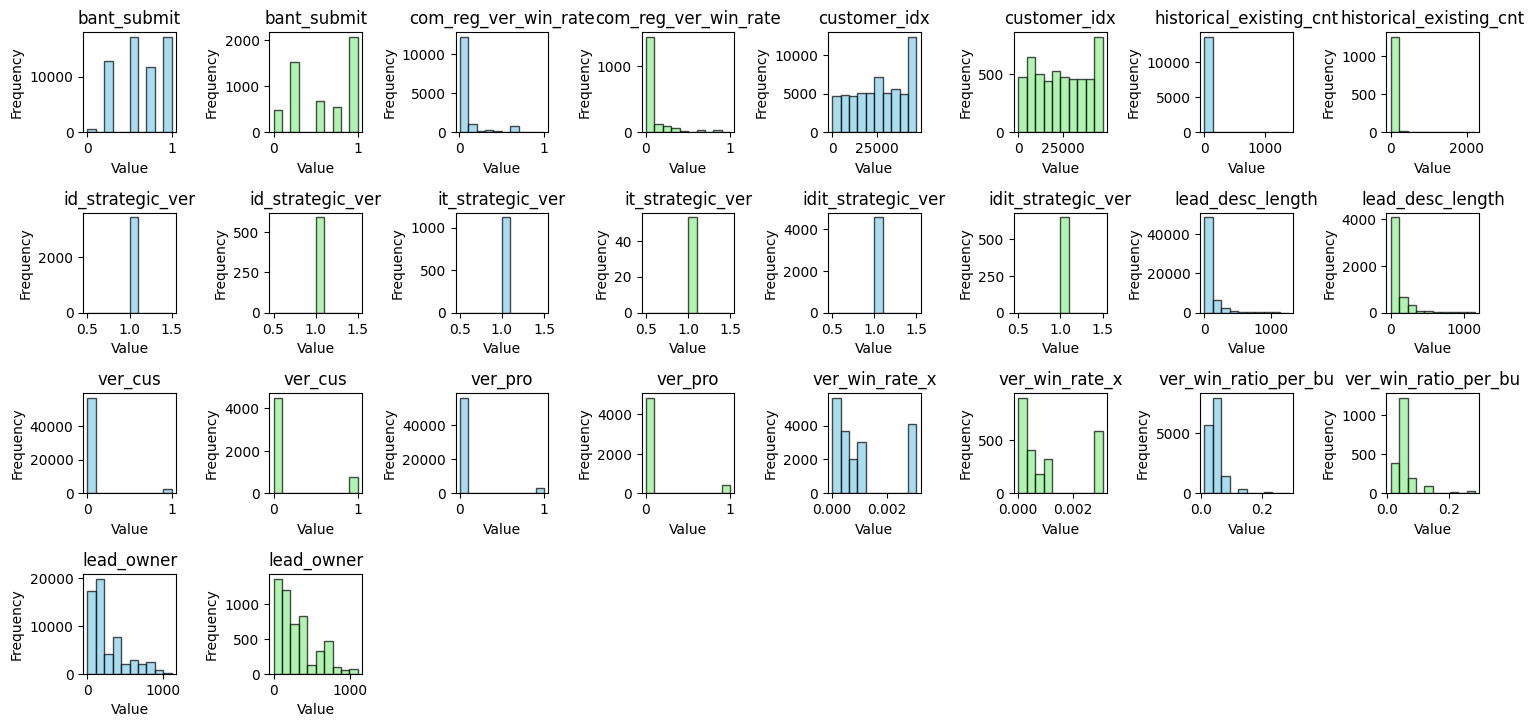

In [ ]:
# Ïà´ÏûêÌòï Îç∞Ïù¥ÌÑ∞Îßå Ï∂îÏ∂ú (id Ï†úÏô∏)
numeric_train_df = data.loc[train_index,numeric_columns]
numeric_test_df = data.loc[test_index,numeric_columns]

# Ïà´ÏûêÌòï Îç∞Ïù¥ÌÑ∞Ïùò Í∞úÏàòÏôÄ ÌûàÏä§ÌÜ†Í∑∏Îû® subplot ÏÉùÏÑ±
num_rows = 14
num_cols = 8
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 25))

# Í∞Å Ïà´ÏûêÌòï Îç∞Ïù¥ÌÑ∞ Ïª¨ÎüºÏóê ÎåÄÌï¥ ÌûàÏä§ÌÜ†Í∑∏Îû® Í∑∏Î¶¨Í∏∞
for i, col in zip(range(0,len(numeric_train_df)*2,2),numeric_columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].hist(numeric_train_df[col], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
    axes[row_idx, col_idx].set_title(col)
    axes[row_idx, col_idx].set_xlabel('Value')
    axes[row_idx, col_idx].set_ylabel('Frequency')

    axes[row_idx, col_idx+1].hist(numeric_test_df[col], bins=10, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[row_idx, col_idx+1].set_title(col)
    axes[row_idx, col_idx+1].set_xlabel('Value')
    axes[row_idx, col_idx+1].set_ylabel('Frequency')

# Îπà subplot Ïà®Í∏∞Í∏∞
for i in range(len(numeric_train_df.columns)*2, num_rows*num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    fig.delaxes(axes[row_idx, col_idx])

#Í∑∏ÎûòÌîÑ Ï∂úÎ†•
plt.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x7a6bcf502c80>,
 [Text(False, 0, 'False'), Text(True, 0, 'True')])

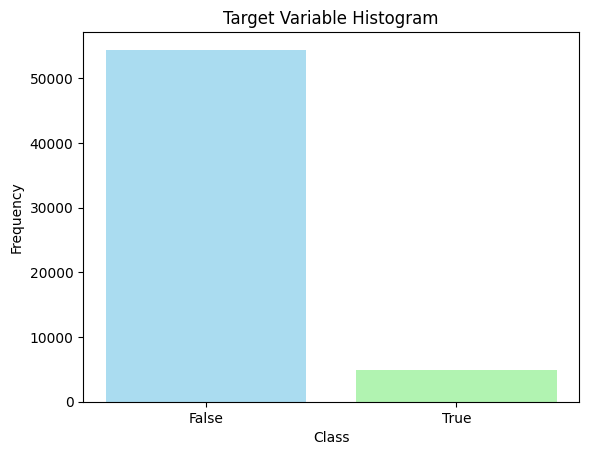

In [ ]:
# ÎπàÎèÑÏàòÎ•º ÏãúÍ∞ÅÌôîÌïòÎäî ÌûàÏä§ÌÜ†Í∑∏Îû® Í∑∏Î¶¨Í∏∞
target_name = list(data.loc[train_index,'is_converted'].value_counts().index)
target_freq = list(data.loc[train_index,'is_converted'].value_counts().values)
plt.bar(target_name, target_freq, color= ['skyblue', 'lightgreen'], alpha=0.7)

# Í∑∏ÎûòÌîÑ Ï†úÎ™©Í≥º Ï∂ï Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title('Target Variable Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

# xÏ∂ïÏóê ÎùºÎ≤®ÎßÅ
plt.xticks(target_name, ['False', 'True'])

# Í∑∏ÎûòÌîÑ Ï∂úÎ†•
# plt.show()

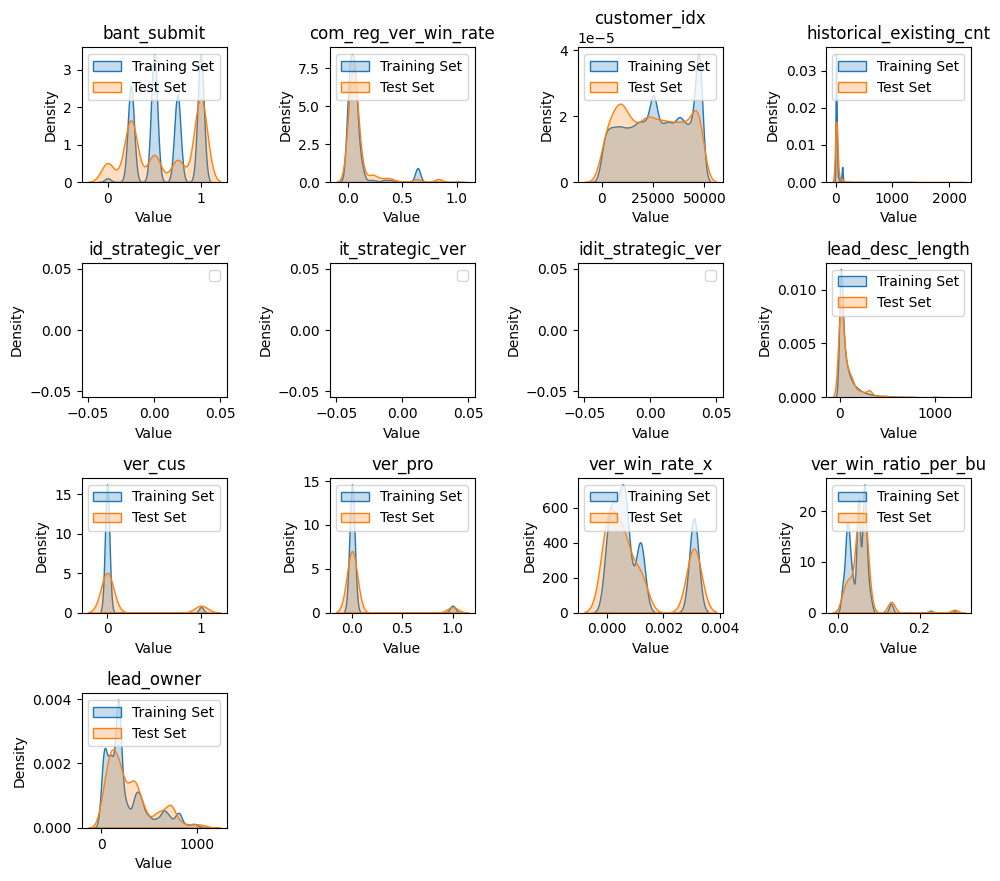

<Figure size 640x480 with 0 Axes>

In [ ]:
# Ïà´ÏûêÌòï Îç∞Ïù¥ÌÑ∞Ïùò Í∞úÏàòÏôÄ KDE plot subplot ÏÉùÏÑ±
num_rows = 14
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 30), squeeze=False)

# Í∞Å Ïà´ÏûêÌòï Îç∞Ïù¥ÌÑ∞ Ïª¨ÎüºÏóê ÎåÄÌï¥ KDE plot Í∑∏Î¶¨Í∏∞ (inst_id, OC Ï†úÏô∏)
for i, col in enumerate(numeric_columns):
    row_idx = i//num_cols
    col_idx = i%num_cols

    sns.kdeplot(numeric_train_df[col], bw_method='silverman', label='Training Set', shade=True, ax=axes[row_idx, col_idx])
    sns.kdeplot(numeric_test_df[col], bw_method='silverman', label='Test Set', shade=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(col)
    axes[row_idx, col_idx].set_xlabel('Value')
    axes[row_idx, col_idx].set_ylabel('Density')
    axes[row_idx, col_idx].legend()

# Îπà subplot Ïà®Í∏∞Í∏∞
for i in range(len(numeric_train_df.columns), num_rows*num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    fig.delaxes(axes[row_idx, col_idx])

plt.tight_layout()
plt.show()

# Í∑∏ÎûòÌîÑ Ï∂úÎ†•
plt.tight_layout()
plt.show()

#### ‚ùó log Î≥ÄÌôò
- ['historical_existing_cnt', 'lead_desc_length']Ïùò Î∂ÑÌè¨Í∞Ä ÏôºÏ™ΩÏúºÎ°ú ÏπòÏö∞Ïßê
- log Î≥ÄÌôò ÌõÑ Ïù¥ÏÉÅÏπò ÏãúÍ∞ÅÌôî

In [ ]:
features = ['historical_existing_cnt', 'lead_desc_length']

# ÏÑ†ÌÉùÌïú Ïó¥Ïóê Î°úÍ∑∏ Î≥ÄÌôò Ï†ÅÏö©
df_train[features] = np.log1p(df_train[features])
df_test[features] = np.log1p(df_test[features])

# Ïà´ÏûêÌòï Îç∞Ïù¥ÌÑ∞Îßå Ï∂îÏ∂ú (id Ï†úÏô∏)
numeric_train_df = df_train[numeric_columns]
numeric_test_df = df_test[numeric_columns]

## 1-3. Ïù¥ÏÉÅÏπò ÏãúÍ∞ÅÌôî

Ïù¥ÏÉÅÏπòÏóê ÎåÄÌï¥ÏÑú Ïñ¥ÎñªÍ≤å Ï≤òÎ¶¨Ìï†ÏßÄ Í≥†ÎØºÏ§ë

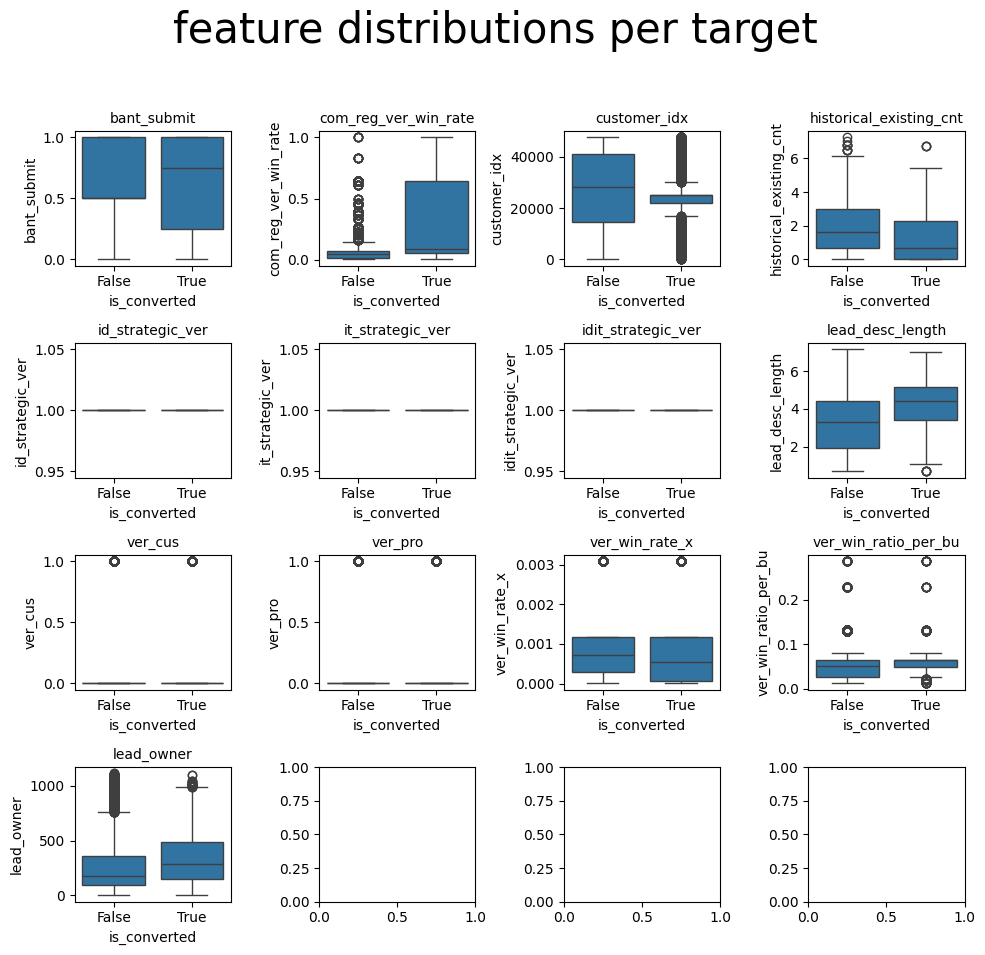

In [ ]:
#Î∞ïÏä§ÌîåÎ°Ø
numeric_train_df.index = df_train.index
numeric_train_df['is_converted'] = df_train['is_converted']

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('feature distributions per target', fontsize= 30)
for ax, col in zip(axes.flat, numeric_train_df.columns[:-1]):
    sns.boxplot(x= 'is_converted', y= col, ax=ax, data=numeric_train_df)
    ax.set_title(col, fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

In [ ]:
# def outliers_iqr(data):
#     q1, q3 = np.percentile(data, [25, 75])
#     # ÎÑòÌååÏù¥Ïùò Í∞íÏùÑ ÌçºÏÑºÌä∏Î°ú ÌëúÏãúÌï¥Ï£ºÎäî Ìï®Ïàò

#     iqr = q3 - q1
#     lower_bound = q1 - (iqr * 1.5)
#     upper_bound = q3 + (iqr * 1.5)

#     return np.where((data > upper_bound) | (data < lower_bound))

# 2. ‚≠ï Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

## 2-1. ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ï§ë Í≤∞Ï∏°Í∞íÏù¥ ÎßéÏùÄ Îç∞Ïù¥ÌÑ∞ ÏÇ≠Ï†ú

In [ ]:
# Ìïú ÌñâÏóê NullÍ∞í 16Ïù¥ÏÉÅ Ï†úÍ±∞
# ÌïôÏäµÌïòÎäîÎç∞Ïóê Î∞©Ìï¥Îê† Í≤É Í∞ôÏùå
del_nan_train_df = df_train[df_train.isnull().sum(axis=1) <= 15].copy()

print('Í∏∞Ï°¥ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ìñâ Í∞úÏàò: %d' %len(df_train))
print('Í≤∞Ï∏°Í∞íÏù¥ ÎßéÏùÄ Îç∞Ïù¥ÌÑ∞Î•º ÏÇ≠Ï†úÌïú ÌõÑ, ÎÇ®ÏùÄ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò Ìñâ Í∞úÏàò: %d' %len(del_nan_train_df))

# ÌïôÏäµÎç∞Ïù¥ÌÑ∞ index ÏóÖÎç∞Ïù¥Ìä∏
train_index = del_nan_train_df.index

Í∏∞Ï°¥ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ìñâ Í∞úÏàò: 59299
Í≤∞Ï∏°Í∞íÏù¥ ÎßéÏùÄ Îç∞Ïù¥ÌÑ∞Î•º ÏÇ≠Ï†úÌïú ÌõÑ, ÎÇ®ÏùÄ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò Ìñâ Í∞úÏàò: 59178


## 2-2. Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ ÏÇ≠Ï†ú

In [ ]:
## Îç∞Ïù¥ÌÑ∞Ïùò Ï§ëÎ≥µ Ï†úÍ±∞
del_dup_train_df = del_nan_train_df.drop_duplicates()
print('Í∏∞Ï°¥ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ìñâ Í∞úÏàò: %d' %len(del_nan_train_df))
print('Ï§ëÎ≥µÍ∞íÏùÑ Ï†úÍ±∞Ìïú ÌõÑ, ÎÇ®ÏùÄ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò Ìñâ Í∞úÏàò: %d' %len(del_dup_train_df))

# ÌïôÏäµÎç∞Ïù¥ÌÑ∞ index ÏóÖÎç∞Ïù¥Ìä∏
train_index = del_dup_train_df.index

Í∏∞Ï°¥ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ìñâ Í∞úÏàò: 59178
Ï§ëÎ≥µÍ∞íÏùÑ Ï†úÍ±∞Ìïú ÌõÑ, ÎÇ®ÏùÄ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò Ìñâ Í∞úÏàò: 55664


## 2-3. ÌïôÏäµÏóê Î∞©Ìï¥ÎêòÎäî Ïó¥ drop

In [ ]:
new_train_df = del_dup_train_df.copy()
new_test_df = df_test.copy()

In [ ]:
# 22. ver_cus			ÌäπÏ†ï Vertical Level 1(ÏÇ¨ÏóÖÏòÅÏó≠) Ïù¥Î©¥ÏÑú Customer_type(Í≥†Í∞ù Ïú†Ìòï)Ïù¥ ÏÜåÎπÑÏûê (End-user)Ïù∏ Í≤ΩÏö∞Ïóê ÎåÄÌïú Í∞ÄÏ§ëÏπò
# 23. ver_pro			ÌäπÏ†ï Vertical Level 1(ÏÇ¨ÏóÖÏòÅÏó≠) Ïù¥Î©¥ÏÑú ÌäπÏ†ï Product Category(Ï†úÌíà Ïú†Ìòï)Ïù∏ Í≤ΩÏö∞Ïóê ÎåÄÌïú Í∞ÄÏ§ëÏπò
## Í∞ÄÏ§ëÏπòÏóê Í¥ÄÌïú Ïó¥ Ï§ëÏöîÌïòÏßÄ ÏïäÎã§Í≥† ÌåêÎã®, drop

new_train_df.drop(['ver_cus','ver_pro','id_strategic_ver','it_strategic_ver','idit_strategic_ver','customer_country.1'], axis=1, inplace=True)
new_test_df.drop(['id','ver_cus','ver_pro','id_strategic_ver','it_strategic_ver','idit_strategic_ver','customer_country.1'], axis=1, inplace=True)

print('Í∏∞Ï°¥ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò Ïó¥ Í∞úÏàò: %d' %len(del_dup_train_df.columns))
print('Ï§ëÎ≥µÎêú Í∞íÏùÑ Í∞ÄÏßÄÎäî Ïó¥ÏùÑ ÏÇ≠Ï†úÌïú ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò Ïó¥ Í∞úÏàò: %d' %len(new_train_df.columns))
print('')
print('Í∏∞Ï°¥ ÏãúÌóò Îç∞Ïù¥ÌÑ∞Ïùò Ïó¥ Í∞úÏàò: %d' %len(df_test.columns))
print('Ï§ëÎ≥µÎêú Í∞íÏùÑ Í∞ÄÏßÄÎäî Ïó¥ÏùÑ ÏÇ≠Ï†úÌïú ÏãúÌóò Îç∞Ïù¥ÌÑ∞Ïùò Ïó¥ Í∞úÏàò: %d' %len(new_test_df.columns))

Í∏∞Ï°¥ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò Ïó¥ Í∞úÏàò: 29
Ï§ëÎ≥µÎêú Í∞íÏùÑ Í∞ÄÏßÄÎäî Ïó¥ÏùÑ ÏÇ≠Ï†úÌïú ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò Ïó¥ Í∞úÏàò: 23

Í∏∞Ï°¥ ÏãúÌóò Îç∞Ïù¥ÌÑ∞Ïùò Ïó¥ Í∞úÏàò: 29
Ï§ëÎ≥µÎêú Í∞íÏùÑ Í∞ÄÏßÄÎäî Ïó¥ÏùÑ ÏÇ≠Ï†úÌïú ÏãúÌóò Îç∞Ïù¥ÌÑ∞Ïùò Ïó¥ Í∞úÏàò: 22


## 2-4. Î≤îÏ£ºÌòï Îç∞Ïù¥ÌÑ∞ cleaning
‚¨ú : ÏàòÏ†ïÌïÑÏöî üü¶ : ÏôÑÎ£å

In [ ]:
label_columns = [
    "customer_country",
    "business_area", "business_subarea",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]
numerical_features = [
  'bant_submit',
  'com_reg_ver_win_rate',
  'historical_existing_cnt',
  'lead_desc_length',
  'ver_win_rate_x',
  'ver_win_ratio_per_bu',
]

### ‚úî Ï†ÑÏ≤òÎ¶¨ ÏßÑÌñâ Ï†Ñ category ÏÉÅÏúÑ Î≤îÏ£ºÍ∞í Ï∞æÍ∏∞
- , Î°ú Î∂ÑÎ•òÎêú Îç∞Ïù¥ÌÑ∞Îì§ÏùÄ integrated solutionÏóê Ìè¨Ìï®

In [ ]:
def is_top_category(text):

  if pd.isna(text):
        return np.nan

  if ',' in text:
    return True
  else:
    return False

top_category = new_train_df['product_category'].apply(is_top_category)

In [ ]:
top_category = top_category.fillna(False)

### üü¶ ÌäπÏàòÎ¨∏Ïûê/Í≥µÎ∞±/Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Í∞íÎì§ ÏÇ¨Ïù¥Ïóê ÏùòÎØ∏Îäî Í∞ôÏßÄÎßå Ïó¨Î∞±Ïù¥ Ï°¥Ïû¨Ìï¥ÏÑú Îã§Î•¥Í≤å Ï≤òÎ¶¨Ìï† Ïàò ÏûàÏùå
import string
import re

def remove_punctuation(text):
    if pd.isna(text):
        return np.nan

    text = re.sub('[~_-]', ' ', text)
    text = re.sub('[,&(]', ' ', text)
    text = re.sub('[).]', ' ', text)
    text = text.rstrip()
    text = text.lstrip()
    text = re.sub('\s\s', ' ', text)
    text = re.sub('\s\s', ' ', text)  # ÎùÑÏñ¥Ïì∞Í∏∞ Ïó∞ÏÜç Ï†úÍ±∞

    return text

def remove_slash(text):
    if pd.isna(text):
        return np.nan
    return re.sub('/', ' ', text)

In [ ]:
new_train_df[numerical_features] = new_train_df[numerical_features].fillna(0)
new_train_df[numerical_features] = new_train_df[numerical_features].fillna(0)

In [ ]:
for feature in label_columns:
  new_train_df[feature] = new_train_df[feature].str.lower()
  new_train_df[feature] = new_train_df[feature].apply(remove_punctuation)

  new_test_df[feature] = new_test_df[feature].str.lower()
  new_test_df[feature] = new_test_df[feature].apply(remove_punctuation)

### üü¶ ÏòÅÏñ¥ Ïô∏Ïùò Ïñ∏Ïñ¥ >> ÏòÅÏñ¥Î°ú

In [ ]:
!pip install googletrans==3.1.0a0

In [ ]:
from googletrans import Translator
translator = Translator()

def en_dic(df,col):
    unique_value = df[col].unique()
    trans_dic = {}

    for sen in unique_value:
        if sen is np.nan:
            trans_dic[sen] = sen
            continue

        non_alpha_chars = re.sub(r'\W+', '', sen)
        non_alpha_chars = re.search(r'[^a-zA-Z0-9]', non_alpha_chars)

        if non_alpha_chars:
            changed_chars = translator.translate(sen, dest='en').text
            trans_dic[sen] = changed_chars

    return trans_dic

def to_english(df,col):
    # en_dicÏóê ÏûàÎäî Í∞íÏù¥Î©¥ Ìï¥Îãπ Ìñâ Í∞íÏùÑ ÏÇ¨Ï†ÑÏùò Í∞íÏúºÎ°ú ÍµêÏ≤¥
    df[col] = df[col].apply(lambda x: dic[x] if x in dic else x)

In [ ]:
need_to_en = ['customer_job' , 'inquiry_type' , 'product_category' , 'product_subcategory' , 'product_modelname']
for n in need_to_en:
    dic = en_dic(new_train_df, n)
    to_english(new_train_df, n)

for n in need_to_en:
    dic = en_dic(new_train_df,n)
    to_english(new_train_df,n)

### üü¶ customer_country
- '/'Î•º Í∏∞Ï§ÄÏúºÎ°ú countryÏôÄ city ÎÇòÎàÑÍ∏∞
- country Í≤∞Ï∏°Ïπò Í∞í cityÍ∞íÏùÑ ÌÜµÌï¥ Ï±ÑÏö∞Í∏∞

In [ ]:
# Íµ≠Í∞ÄÏóê ÎåÄÌïú ÏÜåÎèÑÏãú Îã®ÏúÑ Ï†úÍ±∞, Íµ≠Í∞Ä Îã®ÏúÑÏùò Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÎäî Í≤ΩÏö∞ nan Ï≤òÎ¶¨
# ÎßåÏïΩ Íµ≠Í∞Ä Îã®ÏúÑÎßå ÏóÜÍ≥† ÏàòÎèÑÎßå ÏûàÎäî Í≤ΩÏö∞ ÏàòÎèÑ Ïù¥Î¶ÑÏúºÎ°ú ÎåÄÏ≤¥
def process_country(country):
    result = np.nan

    if pd.isna(country):
        return np.nan

    if "/" not in str(country):
        return np.nan

    parts = [x.strip() for x in country.split('/')]  # Î™®Îì† ÏöîÏÜåÎ•º Ìè¨Ìï®ÌïòÏó¨ Î∂ÑÌï†

    if len(parts) >= 1 and parts[-1] != '':
        return parts[-1]
    else:
        return np.nan

    if '@' in str(result):
        return np.nan

    return result


def process_city(city):

    result = np.nan

    if pd.isna(city):
        return np.nan

    if "/" not in str(city):
        return np.nan

    parts = [x.strip() for x in city.split('/')]  # Î™®Îì† ÏöîÏÜåÎ•º Ìè¨Ìï®ÌïòÏó¨ Î∂ÑÌï†

    if len(parts) >= 2 and parts[-2] != '':
        return parts[-2]
    else:
        return np.nan

    if '@' in str(result):
        return np.nan

    return result
# ÏÇ¨Ïù¥Ìä∏ Ï∞∏Í≥†
us_states = [
    "al", "ak", "az", "ar", "ca", "co", "ct", "de", "fl", "ga",
    "hi", "ia", "id", "il", "in", "ks", "ky", "la", "ma", "md",
    "me", "mi", "mn", "ms", "mo", "mt", "nc", "nd", "ne", "nh",
    "nj", "nm", "nv", "ny", "oh", "ok", "or", "pa", "ri", "sc",
    "sd", "tn", "tx", "ut", "vt", "va", "wa", "wi", "wv", "wy",
    "usa", "zip","us", "ohio", "48201", "nevada",
    "hampshire",
    ]

india_states = [
    "odisha", "indore", "kerela", "gujarat", "uttar",
    "gurgaon", "anand", "pune", "lucknow", "bhilwara",
    "chennai", "hyderabad", "telangana", "mumbai","bangalore"]

brazil_states = [
    'br', 'rj'
]

other = [
    'country'
]

def process_unique(country):

  if pd.isna(country):
        return np.nan

  if 'united states' in country:
    return 'us'

  is_states = country.split()

  for state in is_states:
    if state in us_states:
      return 'us'
    elif state in india_states:
      return 'india'
    elif state in brazil_states:
      return 'brazil'
    elif state == 'netherlands':
      return 'nethernads'
    elif state == 'colombia':
      return 'colombia'
    elif state in other:
      return np.nan
  else:
    return country


In [ ]:
print("train set")

new_train_df['country'] = new_train_df['customer_country'].apply(process_country)
print("Ï†ÑÏ≤òÎ¶¨ Ï†Ñ country nunique:",new_train_df['country'].nunique())

new_train_df['country'] = new_train_df['country'].apply(process_unique)

new_train_df['country'] = new_train_df['country'].replace("a", np.nan)
new_train_df['country'] = new_train_df['country'].replace("u a e", "uae")
new_train_df['country'] = new_train_df['country'].replace("uae dubai", "uae")

print("Ï†ÑÏ≤òÎ¶¨ ÌõÑ country nunique:",new_train_df['country'].nunique())
## city
new_train_df['city'] = new_train_df['customer_country'].apply(process_city)
new_train_df['city'] = new_train_df['city'].replace("dubai uae", "dubai")
# ------------ test
print("test set")
new_test_df['customer_country'] = new_test_df['customer_country'].replace("uae dubai", "uae")

new_test_df['country'] = new_test_df['customer_country'].apply(process_country)
print("Ï†ÑÏ≤òÎ¶¨ Ï†Ñ country nunique:",new_test_df['country'].nunique())

new_train_df['country'] = new_train_df['country'].replace("a", np.nan)
new_train_df['country'] = new_train_df['country'].replace("u a e", "uae")
new_train_df['country'] = new_train_df['country'].replace("uae dubai", "uae")

new_test_df['country'] = new_test_df['country'].apply(process_unique)
print("Ï†ÑÏ≤òÎ¶¨ ÌõÑ country nunique:",new_test_df['country'].nunique())

## city
new_test_df['city'] = new_test_df['customer_country'].apply(process_city)
new_test_df['city'] = new_test_df['city'].replace("dubai uae", "dubai")

train set
Ï†ÑÏ≤òÎ¶¨ Ï†Ñ country nunique: 269
Ï†ÑÏ≤òÎ¶¨ ÌõÑ country nunique: 171
test set
Ï†ÑÏ≤òÎ¶¨ Ï†Ñ country nunique: 94
Ï†ÑÏ≤òÎ¶¨ ÌõÑ country nunique: 87


In [ ]:
new_train_df.drop(['customer_country'],axis=1,inplace=True)
new_test_df.drop(['customer_country'],axis=1,inplace=True)

In [ ]:
new_train_df[new_train_df['country'] == 'uae']['is_converted'].value_counts()

False    1317
True      213
Name: is_converted, dtype: int64

In [ ]:
new_train_df['country'].unique()

array(['philippines', 'india', 'nigeria', 'saudi arabia', 'singapore',
       'brazil', 'uae', 'south africa', 'us', 'colombia', 'mexico',
       'ghana', 'egypt', 'democratic republic of the congo', 'ethiopia',
       'australia', nan, 'kenya', 'indonesia', 'oman', 'pakistan',
       'united kingdom', 'guatemala', 'panama', 'canada', 'bangladesh',
       'papua new guinea', 'united republic of tanzania', 'qatar',
       'afghanistan', 'chile', 'mozambique', 'turkey', 't√ºrkiye',
       'el salvador', 'togo', 'jordan', 'iraq', 'israel', 'sri lanka',
       'south korea', 'portugal', 'mauritania', 'uruguay', 'peru',
       'germany', 'romania', 'norway', 'jamaica', 'hungary', 'poland',
       'czech', 'spain', 'argentina', 'ecuador', 'senegal', 'hong kong',
       'malaysia', 'japan', 'kuwait', 'ireland', 'albania', 'greece',
       'algeria', 'nicaragua', 'slovenia', 'italy', 'nethernads',
       'dominican republic', 'france', 'uganda', 'iran', 'paraguay',
       'bolivia', 'namibia',

country Ïó¥ Í≤∞Ï∏°ÏπòÍ∞í city Ïó¥ Ïù¥Ïö©Ìï¥ÏÑú Ï±ÑÏö∞Í∏∞

In [ ]:
print('ÎèÑÏãúÍ∞íÏúºÎ°ú Í≤∞Ï∏°Ïπò Ï±ÑÏö∞Í∏∞ Ï†Ñ country Í≤∞Ï∏°Ïπò Í∞úÏàò')
new_train_df['country'].isnull().sum()

ÎèÑÏãúÍ∞íÏúºÎ°ú Í≤∞Ï∏°Ïπò Ï±ÑÏö∞Í∏∞ Ï†Ñ country Í≤∞Ï∏°Ïπò Í∞úÏàò


3938

In [ ]:
# new_train_df[(new_train_df['country'].isna()) & (~new_train_df['city'].isna())]['city'].value_counts().iloc[:50]

In [ ]:
city_to_country = {
    'uae': ['abudhabi','rak','ÿØÿ®Ÿä','al ain','uae','dubai', 'abu dhabi', 'sharjah', 'ajman', 'ras al khaimah', 'ÿßÿ®Ÿàÿ∏ÿ®Ÿä', 'deira', 'ÿßŸÑÿ¥ÿßÿ±ŸÇÿ©', 'alain', 'ÿπÿ¨ŸÖÿßŸÜ', 'fujairah','dubai uae', 'shj', 'ras al khaima'],

    'us': ['new york', 'houston', 'phoenix', 'washington', 'miami', 'los angeles', 'tampa', 'newark', 'chicago', 'san diego', 'indianapolis', 'san antonio', 'salt lake city', 'el paso',
           'austin', 'wichita', 'jacksonville', 'virginia beach', 'san francisco', 'omaha', 'orlando', 'las vegas', 'anaheim', 'philadelphia', 'tucson', 'danville', 'buffalo', 'bellevue',
           'columbus', 'lubbock', 'irvine', 'scottsdale', 'detroit', 'grand rapids', 'fort lauderdale', 'nashville', 'charlotte', 'seattle', 'south bend', 'boca raton', 'new orleans', 'alpharetta',
           'raleigh', 'charleston', 'tulsa', 'greenville', 'spring', 'sacramento', 'providencaies', 'topeka', 'fayetteville', 'atlanta', 'aurora', 'cincinnati', 'hollywood', 'eglin afb', 'montgomery',
           'lincoln', 'irving', 'apo', 'champaign', 'norcross', 'plano', 'federal way', 'silver spring', 'maroa', 'naperville', 'dallas', 'columbia', 'minneapolis', 'boston', 'rancho cucamonga', 'oklahoma city',
           'morristown', 'fort collins', 'baltimore', 'offutt afb', 'saint petersburg', 'santa monica', 'fort worth', 'decatur', 'woodhaven', 'schaumburg', 'mahopac', 'winston', 'birmingham', 'amherst', 'coalgate', 'chesterfield',
           'brooklyn','kansas city','sierra vista', 'bell gardens', 'pigeon forge', 'delray beach', 'augusta', 'cloverdale', 'cypress', 'staten island', 'harrisburg', 'north hollywood', 'colorado springs',
           'olathe', 'elkhart', 'sunnyvale', 'flushing', 'peachtree corners', 'cambridge', 'albuquerque', 'san marcos', 'gaithersburg', 'san jose', 'costa mesa', 'reston', 'malvern', 'dexter', 'jackson',
           'ras al khaima', 'monrovia', 'bridgeport', 'katy', 'long beach', 'bowie', 'lexington', 'lakewood', 'la jolla', 'overland park', 'miami gardens', 'hapeville', 'camden', 'orting', 'richmond'],

    'philippines': ['manila', 'makati', 'quezon city', 'mandaluyong','makati city'],
    'india': ['bangalore', 'mumbai','bengaluru'],
    'saudi arabia': ['riyadh', 'ÿßŸÑÿ±Ÿäÿßÿ∂','riaydh', 'khobar'],
    'oman': ['muscat'],
    'egypt': ['cairo'],
    'kuwait': ['ÿßŸÑŸÉŸàŸäÿ™'],
    'sri lanka': ['colombo 03'],
    'united kingdom': ['liverpool'],
}


In [ ]:
# country Ïó¥Ïù¥ NaNÏù¥Í≥† city Ïó¥ Í∞íÏù¥ ÎîïÏÖîÎÑàÎ¶¨Ïùò ÎèÑÏãúÏóê Ìï¥ÎãπÌïòÎäî Í≤ΩÏö∞Ïóê ÎåÄÌï¥ country Í∞íÏùÑ Ìï¥Îãπ ÎèÑÏãúÏóê ÎåÄÏùëÌïòÎäî Íµ≠Í∞ÄÎ°ú Ï±ÑÏõÄ
new_train_df['country'] = new_train_df.apply(lambda row: next((key for key, value in city_to_country.items() if pd.isna(row['country']) and row['city'] in value), row['country']), axis=1)
new_test_df['country'] = new_test_df.apply(lambda row: next((key for key, value in city_to_country.items() if pd.isna(row['country']) and row['city'] in value), row['country']), axis=1)

In [ ]:
print('ÎèÑÏãúÍ∞íÏúºÎ°ú Í≤∞Ï∏°Ïπò Ï±ÑÏö¥ ÌõÑ country Í≤∞Ï∏°Ïπò Í∞úÏàò')
new_train_df['country'].isnull().sum()

ÎèÑÏãúÍ∞íÏúºÎ°ú Í≤∞Ï∏°Ïπò Ï±ÑÏö¥ ÌõÑ country Í≤∞Ï∏°Ïπò Í∞úÏàò


3386

In [ ]:
new_train_df[['country', 'city']] = new_train_df[['country', 'city']].fillna('other')
new_test_df[['country', 'city']] = new_test_df[['country', 'city']].fillna('other')

In [ ]:
label_columns = [
    "country","city",
    "business_area", "business_subarea",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

### üü¶ response_corporate
- ÏïûÏùò Î¨∏ÏûêÏó¥ Í≥µÌÜµ 'lge' Ï†úÍ±∞


In [ ]:
new_train_df['response_corporate'] = new_train_df['response_corporate'].str.replace("lge", "")
new_test_df['response_corporate'] = new_test_df['response_corporate'].str.replace("lge", "")

In [ ]:
new_test_df['response_corporate']

0       sp
1       us
2       gf
3       us
4       sp
        ..
5266    sp
5267    us
5268    sp
5269    dg
5270    il
Name: response_corporate, Length: 5271, dtype: object

### üü¶  inquiry_type

In [ ]:
# Other, Others, Etc., ETC., Not specified  >> ÎòëÍ∞ôÏùÄ Îç∞Ïù¥ÌÑ∞Î°ú Ï≤òÎ¶¨ : other
# Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨ >> other
def process_etc(data):
    if data in [
        'other', 'others', 'etc.', 'not specified', 'none',
        'Other Stores', 'Others', 'nan', 'etc', 'no longer available','not applicable','no influence',
        ]:
        return np.nan
    else:
        return data

def process_inquiry(df):
  df['inquiry_type'].replace({
      'purchase' : 'quotation or purchase consultation',
      'quotation' : 'quotation or purchase consultation',
      'purchase or quotation' : 'quotation or purchase consultation',
      'hola me pueden cotizar 19 pantallas interactivas de 100 pulgadas entregadas en guayaquil ecuador' : 'quotation or purchase consultation',
      'Please give me a quote for the body temperature measurement product, thank you' : 'quotation or purchase consultation',
      'probeam precio' : 'quotation or purchase consultation',
      'I request support to make a quote for the devices they offer in the one quick solution' : 'quotation or purchase consultation',
      'please give me a quote for the body temperature measurement product, thank you' : 'quotation or purchase consultation',
      'i request support to make a quote for the devices they offer in the one quick solution:' : 'quotation or purchase consultation',
      'i need to consult prices and solutions from lg' : 'quotation or purchase consultation',

      'usage_or_technical_consultation' : 'usage or technical consultation',
      'I need to consult prices and solutions from LG' : 'usage or technical consultation',

      'technical support' : 'technical consultation',
      'technical' : 'technical consultation',

      'one quick:flex' : 'product information',
      'aio' : 'product information',
      'i want to know the details about it' : 'product information',
      'hospital tv' : 'product information',
      'educational equipments' : 'product information',
      'tv interactive' : 'product information',
      'digital platform' : 'product information',
      'high inch 86   98 or 110' : 'product information',
      'display textbook and photos' : 'product information',
      'display product' : 'product information',
      'I am looking for this LG magnit micro LED product for Ecuador for a 138-inch client with sea shipping' : 'product information',
      'window facing product' : 'product information',
      'hotel tv products' : 'product information',
      'pantallas interactivas para clinicas' : 'product information',
      'toi muon tim hieu thong tin ky thuat gia ca cua sp de su dung' : 'product information',
      'I need a medical monitor for conventional radiography and tomography' : 'product information',
      'led signage' : 'product information',
      'for school' : 'product information',
      'video wall' : 'product information',
      'first info and pricing' : 'product information',
      'idb' : 'product information',
      'vrf' : 'product information',
      'standalone' : 'product information',
      'high inch 86 / 98 or 110' : 'product information',
      'i am looking for this lg magnit micro led product for ecuador for a 138 inch client with sea shipping' : 'product information',
      'i need a medical monitor for conventional radiography and tomography' : 'product information',


      'evento sdelestero' : 'event inquiry',

      'select id needs' : 'other',
      'needs' : 'other',
      'teach' : 'other',
      'event inquiry' : 'other',
      'media inquiry' : 'other',
      'historical integrator of george v' : 'other',

      'not specified' : 'other',
      'nan' : 'other',
      'no influence' : 'other',
      'not applicable' : 'other',
      'no longer available' : 'other'
      }, inplace = True)

# ÎèôÏùº Î≤îÏ£ºÌòï Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÎåÄÏÜåÎ¨∏Ïûê Íµ¨Î≥Ñ ÏóÜÏï†Í∏∞
new_train_df['inquiry_type'] = new_train_df['inquiry_type'].str.lower()
new_train_df['inquiry_type'] = new_train_df['inquiry_type'].apply(process_etc)


new_test_df['inquiry_type'] = new_test_df['inquiry_type'].str.lower()
new_test_df['inquiry_type'] = new_test_df['inquiry_type'].apply(process_etc)

# ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï≤òÎ¶¨
process_inquiry(new_train_df)

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï≤òÎ¶¨
process_inquiry(new_test_df)

In [ ]:
new_train_df['inquiry_type'].fillna('other', inplace=True)
new_test_df['inquiry_type'].fillna('other', inplace=True)

In [ ]:
for x in new_train_df['inquiry_type'].unique():
    print(x, new_train_df['inquiry_type'].value_counts()[x])

quotation or purchase consultation 40250
product information 1132
other 2156
usage or technical consultation 1118
trainings 376
services 361
sales inquiry 8846
technical consultation 535
request for partnership 273
sales 100
request a demo 174
request for distributorship 67
request for quotation or purchase 221
request for technical consulting 37
customer suggestions 12
oem/odm request 5
event inquiry 1


In [ ]:
for x in new_test_df['inquiry_type'].unique():
    print(x, new_test_df['inquiry_type'].value_counts()[x])

other 1416
quotation or purchase consultation 3465
product information 68
technical consultation 135
request for partnership 63
usage or technical consultation 52
services 34
customer suggestions 4
request a demo 9
trainings 21
oem/odm request 3
request for distributorship 1


### üü¶ customer_type
- ÏÇ¨Ïù¥Ìä∏ Ï∞∏Í≥†ÌïòÏó¨ sub typeÏúºÎ°ú ÏûëÏÑ±Îêú Í≤ΩÏö∞ ÏÉÅÏúÑ typeÏúºÎ°ú Î≥ÄÍ≤ΩÌï¥Ï£ºÎäî ÏûëÏóÖ ÏßÑÌñâ

In [ ]:
new_train_df['customer_type'] = new_train_df['customer_type'].apply(lambda x: x.replace(' ', '') if isinstance(x, str) else x)
new_test_df['customer_type'] = new_test_df['customer_type'].apply(lambda x: x.replace(' ', '') if isinstance(x, str) else x)

new_train_df['customer_type'].replace('enduser', 'endcustomer',inplace=True)
new_train_df['customer_type'].replace('commercialenduser', 'endcustomer',inplace=True)
new_train_df['customer_type'] = new_train_df['customer_type'].apply(process_etc)

new_test_df['customer_type'].replace('enduser', 'endcustomer',inplace=True)
new_test_df['customer_type'].replace('commercialenduser', 'endcustomer',inplace=True)
new_test_df['customer_type'] = new_test_df['customer_type'].apply(process_etc)

In [ ]:
new_train_df['customer_type'].fillna('other', inplace=True)
new_test_df['customer_type'].fillna('other', inplace=True)

In [ ]:
def process_type_mapping(df):
  # ÏÇ¨Ïù¥Ìä∏ Ï∞∏Í≥†ÌïòÏó¨ ÎîïÏÖîÎÑàÎ¶¨ Íµ¨ÏÑ±
  customer_type_mapping =  {
    'endcustomer' : ['construction company', 'owner', 'homeowner', 'developer', 'medical/healthcare facility',
                      'goverment/public sector', 'corporate', 'education', 'retail', 'fitness', 'manager/director', 'administrator'],

    'channelpartner' : ['agent','distributor','reseller','nsp','national reseller','regional reseller', 'si', 'pro', 'var'],

    'specifier/influencer' : ['architect', 'consultant', 'contractor', 'technical/design firm', 'region builder', 'installer', 'ad&contents provider', 'applied rep'],

    'solutionecopartner' : ['cms/webos/isv', 'mount/metal fabrication','meeting solution', 'control/processor', 'external compute'],

    'other' : ['hvacengineer', 'engineer', 'technician', 'systemintegrator'] # Î∂ÑÎ•òÎ•º Ïñ¥ÎñªÍ≤å Ìï¥Ïïº Ìï†ÏßÄ Î™®Î•¥Îäî train uniqueÌïú Í∞íÎì§
    }
  for new_type, keywords in customer_type_mapping.items():
      df.loc[df['customer_type'].str.contains('|'.join(keywords), case=False), 'customer_type'] = new_type

new_train_df['customer_type'] = new_train_df['customer_type'].astype(str)
new_test_df['customer_type'] = new_test_df['customer_type'].astype(str)

# ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï≤òÎ¶¨
process_type_mapping(new_train_df)

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï≤òÎ¶¨
process_type_mapping(new_test_df)

In [ ]:
 new_train_df['customer_type'].value_counts()

other                   41314
endcustomer             10167
specifier/influencer     2433
channelpartner           1306
servicepartner            316
solutionecopartner        128
Name: customer_type, dtype: int64

In [ ]:
new_test_df['customer_type'].value_counts()

endcustomer             2455
other                   1457
specifier/influencer     788
channelpartner           327
solutionecopartner       146
servicepartner            98
Name: customer_type, dtype: int64

### üü¶ customer_position
- ÌïòÎìúÏΩîÎî©ÏúºÎ°ú Î∂ÑÎ•ò

In [ ]:
# Í≥µÌÜµ Ìï®Ïàò Ï†ïÏùò
def process_position(df):
    df['customer_position'].replace({
        'founder' : 'ceo founder',
        'ceo/fundador': 'ceo founder',
        'ceo/founder' : 'ceo founder',
        'co founder': 'ceo founder',
        'mindenes': 'ceo founder',
        'genel m√ºd√ºr': 'ceo founder',
        'leadership/executive office/owner': 'ceo founder',
        'the big boss': 'ceo founder',
        'entrepreneur' : 'ceo founder',
        'entrepreneurship' :'ceo founder',
        'business development': 'ceo founder',
        'chairman': 'ceo founder',
        'president' : 'ceo founder',

        'decision influencer': 'decision-influencer',
        'decision maker': 'decision-influencer',

        'vp': 'vice president',
        'vicepresident':'vice president',
        'visepresident' : 'vice president',
        'gerente': 'vice president',

        'architecture/consult' : 'consultant',
        'architect/consultant': 'consultant',
        'consulting': 'consultant',

        'asst prof' : 'assistant professor',
        'prof' : 'professor',
        'education' : 'professor',
        'educator' : 'professor',
        'education professional': 'professor',
        'f≈ëorvos': 'professor',
        'english trainer for ielts toefl pte gre sat exams' : 'professor',
        'career coach' : 'professor',
        'hon dean' : 'professor',
        'academic specialist' : 'professor',

        'business partner': 'partner',
        'commercial consultant': 'partner',

        'c levelexecutive': 'c level executive',
        'chief executive officer': 'c level executive',

        'entrylevel': 'entry level',

        'lider de desarrollo': 'manager',
        'administrative' : 'manager',
        'market intelligence/research': 'manager',
        'operations': 'manager',

        'business development/sales': 'associate/analyst',

        'principal at oxford integrated pu science college': 'director',
        'professional trainer': 'director',

        'unpaid': 'intern',

        'exhibitiontv': 'exhibition',

        'propriet√°rio a': 'homeowner',

        'this is a consume display requirement for home purpose':'customer',
        'end user': 'customer',
        'commercial end user' : 'customer',

        'surgery professional': 'hospital',
        'tierarzt' : 'hospital',
        'pathologist' : 'hospital',
        'radiology professional' : 'hospital',

        'medical imaging specialist': 'manufacturer',
        'business development/sales': 'manufacturer',
        'carge': 'manufacturer',

        'research': 'software/solution provider',
        'software /solution provider':'software/solution provider',


        'technical' : 'technician',
        't√©cnico' : 'technician',
    }, inplace=True)

    df['customer_position'] = df['customer_position'].str.lower()
    df.loc[df['customer_position'].str.contains('teacher'), 'customer_position'] = 'professor'
    df.loc[df['customer_position'].str.contains('professor'), 'customer_position'] = 'professor'
    df.loc[df['customer_position'].str.contains('lecturer'), 'customer_position'] = 'professor'
    df.loc[df['customer_position'].str.contains('pgt'), 'customer_position'] = 'professor'
    df.loc[df['customer_position'].str.contains('faculty'), 'customer_position'] = 'professor'

    df.loc[df['customer_position'].str.contains('management'), 'customer_position'] = 'manager'

    df.loc[df['customer_position'].str.contains('director'), 'customer_position'] = 'director'

    df.loc[df['customer_position'].str.contains('association'), 'customer_position'] = 'associate/analyst'

    df.loc[df['customer_position'].str.contains('sales'), 'customer_position'] = 'manufacturer'
    df.loc[df['customer_position'].str.contains('manufacturer'), 'customer_position'] = 'manufacturer'

    df['customer_position'] = df['customer_position'].apply(process_etc)

new_train_df['customer_position'] = new_train_df['customer_position'].astype(str)
new_test_df['customer_position'] = new_test_df['customer_position'].astype(str)
# ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï≤òÎ¶¨
process_position(new_train_df)

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï≤òÎ¶¨
process_position(new_test_df)

In [ ]:
new_train_df['customer_position'].fillna('other', inplace=True)
new_test_df['customer_position'].fillna('other', inplace =True)

In [ ]:
for x in new_train_df['customer_position'].unique():
    print(x, new_train_df['customer_position'].value_counts()[x])

entry level 2126
ceo founder 7766
partner 2480
manager 7906
vice president 507
associate/analyst 2507
c level executive 821
other 24567
director 4738
intern 434
trainee 820
customer 433
consultant 27
professor 43
installer 59
homeowner 22
employee 14
bulgaria 7
decision-influencer 26
technician 2
exhibition 4
hospital 203
government 29
manufacturer 40
software/solution provider 26
system integrator 21
distributor 1
engineering 8
cargo 27


In [ ]:
for x in new_test_df['customer_position'].unique():
    print(x, new_test_df['customer_position'].value_counts()[x])

other 2621
manager 726
associate/analyst 279
director 343
entry level 225
ceo founder 594
partner 224
c level executive 85
trainee 49
vice president 54
intern 60
professor 9
customer 2


### üü¶ customer_job (ÏßÑÌñâÏ§ë)
- sentence transformer Ï†ÅÏö©

In [ ]:
!pip install -U sentence-transformers

In [ ]:
# https://www.lg.com/global/business/inquiry-to-buy
# ÏÇ¨Ïù¥Ìä∏ ÎÇ¥ job function Ï∞∏Í≥†
customer_job_list = [
  'accounting', 'administrative', 'arts and design', 'business development',
  'community and social services', 'consulting', 'curation', 'education',
  'engineering', 'entrepreneurship', 'finance', 'healthcare services', 'human resources',
  'information technology', 'legal', 'marketing', 'media and communication',
  'military and protective services', 'operations', 'product management',
  'program and project management', 'purchasing', 'quality assurance',
  'real estate', 'research', 'sales', 'support', 'other'
]

# vertrieb, sonstiges Í∞ôÏùÄ Î≤àÏó≠Ïù¥ ÏïàÎêú Îã®Ïñ¥Îäî Ï≤òÎ¶¨Í∞Ä ÏïàÎê® -> üí•ÏÇ¨Ï†ÑÏóê Î≤àÏó≠ÌïòÎäî ÏΩîÎìú Îçî Ï∂îÍ∞ÄÌï¥ÏïºÌï®üí•
customer_job_replace_words = {
    'sonstiges' : 'other',
    'otro' : 'other',
    'vertrieb' : 'sales'
}

In [ ]:
new_train_df['customer_job'] = new_train_df['customer_job'].apply(process_etc)
new_train_df['customer_job'] = new_train_df['customer_job'].fillna('other')

new_test_df['customer_job'] = new_test_df['customer_job'].apply(process_etc)
new_test_df['customer_job'] = new_test_df['customer_job'].fillna('other')

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
job_embeddings = model.encode(customer_job_list)

In [ ]:
# ÌÖåÏä§Ìä∏ Ìï¥Î≥¥Í∏∞
from sklearn.metrics.pairwise import cosine_similarity

test = 'hr'
test_vector = model.encode([test])

# ÏÉàÎ°úÏö¥ ÏßÅÏóÖÍ≥º Í∏∞Ï°¥ ÏßÅÏóÖÎì§ Í∞ÑÏùò ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞
similarities = cosine_similarity(test_vector, job_embeddings)

# Í∞ÄÏû• Ïú†ÏÇ¨ÎèÑÍ∞Ä ÎÜíÏùÄ ÏßÅÏóÖ Ïπ¥ÌÖåÍ≥†Î¶¨ Ï∞æÍ∏∞
most_similar_index = np.argmax(similarities)
most_similar_job = customer_job_list[most_similar_index]
most_similar_job, np.max(similarities)

('human resources', 0.7098565)

In [ ]:
def preprocess_job(job):
  if isinstance(job, str):
    if job in customer_job_list:
      return job
    else:
      job_vector = model.encode([job])
      similarities = cosine_similarity(job_vector, job_embeddings)

      if np.max(similarities) < 0.4:
        return 'other'
      else:
        most_similar_index = np.argmax(similarities)
        most_similar_job = customer_job_list[most_similar_index]
        return most_similar_job
  else:
    return job

In [ ]:
# 1~2Î∂Ñ Ï†ïÎèÑ ÏÜåÏöî
new_train_df['customer_job'] = new_train_df['customer_job'].apply(preprocess_job)
new_test_df['customer_job'] = new_test_df['customer_job'].apply(preprocess_job)

In [ ]:
new_train_df['customer_job'].value_counts()

other                               22666
engineering                          6083
administrative                       3494
sales                                2407
education                            2272
purchasing                           2027
information technology               1961
operations                           1890
arts and design                      1851
business development                 1747
consulting                           1342
entrepreneurship                     1173
marketing                            1124
healthcare services                  1114
program and project management       1032
media and communication               700
product management                    577
finance                               460
accounting                            394
support                               350
real estate                           294
legal                                 149
community and social services         140
research                          

In [ ]:
new_test_df['customer_job'].value_counts()

other                               1954
engineering                          728
education                            409
administrative                       307
information technology               231
operations                           195
purchasing                           180
consulting                           166
sales                                164
business development                 164
entrepreneurship                     119
arts and design                      104
program and project management        96
marketing                             94
media and communication               49
healthcare services                   49
support                               47
finance                               42
product management                    36
accounting                            34
real estate                           26
community and social services         22
legal                                 17
human resources                       14
research        

### üü¶ product category (ÏßÑÌñâÏ§ë)

In [ ]:
def process_product_category(category):

    if pd.isna(category):
        return np.nan

    # Ïπ¥ÌÖåÍ≥†Î¶¨ ÏπòÌôò ÏÇ¨Ï†Ñ
    category_mapping = {
        'signage': ['awzm', 'lg led bloc', 'gsca', 'gscd', 'lsca039'],
        'tv': ['awz', 'bwz', 'tv signage', 'digital signage or commercial tvs', 'htv', 'tv 60',
               'ctv','tv55', 'tv43pol', 'ur640', 'ur640s', '50uq801c0sb.bwz',
               'uh', 'vl', 'high inch 86 / 98 or 110', '43us660h', 'hoteleria us670h','tv 55'],
        'system ac': ['cac', 'sac', 'vrfcentralairconditioner', 'aire acondicionado residencial', 'systemac', 'onorseveralreversibleac', 'ar condicionado residencial'],
        'vrf': ['vrf', 'variablerefrigerantflow(drv)systems'],
        'video wall': ['wall', '49vl5g', 'vm', '55svh7f a'],
        'procentric': ['centric'],
        'monitor': ['pol', 'monitor', '28mq780', '55tc3d'],
        'multiv': ['multiv'],
        'display': ['display'],
        'audio': ['audio'],
        'aio': ['aio'],
        'led': ['led', 'gscd046', 'laec'],
        'chiller': ['chill'],
        'lg one:quick series': ['lg one:quick', 'aio | one quick', 'onequick series', 'one:quick'],
        'one:quick flex': ['one quick:flex'],
        'washing machine': ['washing'],
        'multi-split': ['multi', 'split'],
        'single-split': ['single', 'split'],
        'projector': ['bu50nst'],
        'board': ['board', 'tr3'],
        'airsolution': ['airsolution', 'acrumah'],
        'other': ['etc.','other']
    }

    # Ïπ¥ÌÖåÍ≥†Î¶¨ ÏπòÌôò
    for key, values in category_mapping.items():
        if any(value in category for value in values):
            return key

    return category

new_train_df['product_category'] = new_train_df['product_category'].apply(process_etc)
new_test_df['product_category'] = new_test_df['product_category'].apply(process_etc)

new_train_df['product_category'] = new_train_df['product_category'].apply(process_product_category)
new_test_df['product_category'] = new_test_df['product_category'].apply(process_product_category)

In [ ]:
new_train_df['product_category'].value_counts().index[0]

'board'

In [ ]:
new_train_df['product_category'].isna().sum()

19060

#### ‚ùóproduct category Í≤∞Ï∏°Ïπò Ï±ÑÏö∞Í∏∞
- sub category , categoryÎäî ÏÉÅÏÜçÍ¥ÄÍ≥Ñ
- ÎßåÏïΩ sub categoryÍ∞Ä Í∞ôÏùÄ Í∞íÏùÑ Í∞ÄÏßÄÎäî Îç∞ categoryÍ∞Ä Îã§Î•∏ Í∞íÏùÑ Í∞ÄÏßÄÎäî Í≤ΩÏö∞ ÌÜµÏùº ÏãúÏºú **Í≤∞Ï∏°Ïπò Ï±ÑÏö∞Í∏∞**

In [ ]:
# ÏµúÎπàÍ∞íÏúºÎ°ú Ï±ÑÏö∞Îäî Îç∞Ïóê Î∞©Ìï¥ÎêòÎäî ÏöîÏÜåÎì§ replace
new_train_df['product_subcategory'].replace("diagnostic monitors\u200b","diagnostic monitors", inplace=True)
new_train_df['product_subcategory'].replace("all medical displays","all medical display", inplace=True)

In [ ]:
from collections import Counter

# categoryÍ∞Ä nullÏù¥Í≥† subcategoryÍ∞Ä nullÏù¥ ÏïÑÎãå ÌñâÏùÑ ÌïÑÌÑ∞ÎßÅ ÌõÑ Î¶¨Ïä§Ìä∏Ïóê Îã¥Í∏∞
missing_category = new_train_df[(new_train_df['product_category'].isna()) & (~new_train_df['product_subcategory'].isna())]
sub_list = missing_category['product_subcategory'].unique().tolist()

# Î¶¨Ïä§Ìä∏Ïóê ÏûàÎäî Í∞íÎì§ Ï§ë categoryÍ∞Ä nullÍ∞íÏù¥ ÏïÑÎãå Í∞íÎì§
filtered_rows = new_train_df[(new_train_df['product_subcategory'].isin(sub_list)) & (~new_train_df['product_category'].isna())][['product_category','product_subcategory']]

# ÎîïÏÖîÎÑàÎ¶¨Ïóê Îß§Ïπ≠
matching_dict = {}


# Í∞Å subcategoryÏóê ÎåÄÌï¥ Í∞ÄÏû• ÎπàÎèÑÍ∞Ä ÎÜíÏùÄ category Í∞íÏùÑ Ï∞æÍ∏∞
for subcategory in sub_list:
    category_counts = Counter(filtered_rows[filtered_rows['product_subcategory'] == subcategory]['product_category'])
    most_common_category = category_counts.most_common(1)
    if most_common_category:
        matching_dict[subcategory] = most_common_category[0][0]
matching_dict

{'oled pro monitor': 'led',
 'diagnostic monitors': 'display',
 'thin clients': 'cloud device',
 'uhd 4k monitors': 'monitor',
 'digital x ray detectors': 'display',
 'zero clients': 'cloud device',
 'all medical display': 'display',
 'clinical review monitors': 'display',
 'ips monitors': 'monitor',
 'surgical monitors': 'display',
 'other': 'display',
 'all monitors pcs': 'monitor',
 'laptops': 'monitor',
 'probeam': 'projector',
 'all cloud devices': 'cloud device',
 'all projectors': 'projector',
 'others': 'monitor',
 'ultrawide‚Ñ¢ monitors': 'monitor',
 'tv monitors': 'monitor',
 'interactive digital board': 'interactive signage'}

In [ ]:
# Í∞í ÌÜµÏùº + Í≤∞Ï∏°Ïπò Ï±ÑÏö∞Í∏∞
for index, row in new_train_df[(new_train_df['product_subcategory'].isin(sub_list))].iterrows():
    if row['product_subcategory'] in matching_dict:
        new_train_df.at[index, 'product_category'] = matching_dict[row['product_subcategory']]

In [ ]:
# new_train_df[new_train_df['product_subcategory'] == 'oled pro monitor'][['product_category','product_subcategory']]

In [ ]:
new_train_df['product_category'].isna().sum()

18779

In [ ]:
# model nameÏúºÎ°úÎèÑ ÎòëÍ∞ôÏù¥ ÏßÑÌñâ

missing_category = new_train_df[(new_train_df['product_category'].isna()) & (~new_train_df['product_modelname'].isna())]
sub_list = missing_category['product_modelname'].unique().tolist()

# Î¶¨Ïä§Ìä∏Ïóê ÏûàÎäî Í∞íÎì§ Ï§ë categoryÍ∞Ä nullÍ∞íÏù¥ ÏïÑÎãå Í∞íÎì§
filtered_rows = new_train_df[(new_train_df['product_modelname'].isin(sub_list)) & (~new_train_df['product_category'].isna())][['product_category','product_modelname']]

# ÎîïÏÖîÎÑàÎ¶¨Ïóê Îß§Ïπ≠
matching_dict = {}

for subcategory in sub_list:
    category_counts = Counter(filtered_rows[filtered_rows['product_modelname'] == subcategory]['product_category'])
    most_common_category = category_counts.most_common(1)
    if most_common_category:
        matching_dict[subcategory] = most_common_category[0][0]
matching_dict

{'lg supersign cms': 'board',
 '55ct5wj 43ht3wj sc 00da': 'procentric',
 'sc 00da': 'lg one:quick series',
 '43ht3wj': 'lg one:quick series',
 '55ct5wj': 'lg one:quick series',
 'ultrafine ergo 32un880': 'display',
 'ergo dual 27qp88d': 'cloud device',
 '32un880': 'monitor',
 '31hn713d': 'display',
 '21hq513d': 'display',
 'ultrawide ergo 34wn780': 'display',
 '28mq780': 'display'}

In [ ]:
for index, row in new_train_df[(new_train_df['product_modelname'].isin(sub_list))].iterrows():
    if row['product_modelname'] in matching_dict:
        new_train_df.at[index, 'product_category'] = matching_dict[row['product_modelname']]

In [ ]:
new_train_df['product_category'].isna().sum()

17425

In [ ]:
new_train_df['product_category'] = new_train_df['product_category'].fillna('other')
new_test_df['product_category'] = new_test_df['product_category'].fillna('other')

#### product category ÏÉÅÏúÑÎ≤îÏ£º ÎßåÎì§Í∏∞

In [ ]:
product_category_dict = {
    # B2B Product Inquiry
    'commmercial display' : ['commercial display', 'digital signage', 'commercial tv',
                             'oled signage', 'led signage', 'video wall signage', 'interactive signage',
                             'high brightness signage','special signage', 'standard signage', 'hotel tv',
                             'hospital tv', 'accessories', 'software solution', 'signage care solution',
                             'webos', 'pro:centric', 'one:quick series'],

    'it products' : ['monitor', 'laptop', 'projector', 'cloud device', 'medical display'],

    'hvac/ess' : ['control', 'ventilation', 'vrf', 'multi split', 'single split', 'chiller', 'heating'],

    'commmercial laundry' : ['titan','giant'],

    'compressor&motor' : ['compressor', 'reciprocating compressor', 'rotary compressor', 'scroll compressor', 'motor'],

    'robot' : ['lg cloi carrybot', 'lg cloi servebot', 'lg cloi servebot', 'lg cloi guidebot'],

    'advanced materials' : ['antimicrobial', 'porcelain enamel', 'specialty glass'],

    # Integrated Solution Inquiry
    'integrated solutions' : ['integrated solutions',
                              'monitor', 'signage', 'commercial tv', 'ess', 'monior monitor tv',
                              'pc', 'projector', 'robot', 'system ac', 'ems', 'rac', 'chiller', 'tv',
                              'refrigerator', 'washing machine', 'aircare', 'vacuum cleaner', 'styler',
                              'dryer', 'built in cooking', 'home beauty', 'water care', 'audio video']
    # === monitor, robot, chillerÏù¥ B2B Product InquiryÍ≥º Ï§ëÎ≥µ === Ïó¨Îü¨Í∞ú ÏÑ†ÌÉùÌï¥ÏÑú Í∑∏Îü∞ÎìØ
    }

product_category_replace_words = {
    'robots' : 'robot',
    'lg one:quick series' : 'one:quick series',
    'lg one:quick' : 'one:quick series',
    'aio | one quick' : 'one:quick series',
    'onequick series' : 'one:quick series',
    'one quick:flex' : 'one:quick series',
    'one:quick flex' : 'one:quick series',
    'one:quick' : 'one:quick series',
    'standard' : 'standard signage',
    'interactive digital board' : 'interactive signage',
    'video wall' : 'video wall signage',
    'high brightness' : 'high brightness signage',

    'multi v 5 air' : 'vrf',
    'multi v' : 'vrf',
    'all lg vrf systems' : 'vrf',
    'kimatyzacja vrf' : 'vrf',

    'klimatyzacja multi split' : 'multi split',

    'teto ou cassete inverter' : 'single split',
    'ar condicionado residencial' : 'single split',
    'residential air conditioner' : 'single split',

    'medical displays' : 'medical display',
    'surgical monitor' : 'monitor',
    'medical monitors' : 'monitor',
    'medical monitor' : 'monitor',

    'uhd signage' : 'digital signage',
    'ur640' : 'digital signage',
    'ur640s' : 'digital signage'
  }

In [ ]:
new_train_df['product_category'][top_category] = 'integrated solutions'

In [ ]:
product_category_list = []

for category in list(product_category_dict.keys()):
  product_category_list = product_category_list + product_category_dict[category]

In [ ]:
new_train_df['product_category'] = new_train_df['product_category'].replace(product_category_replace_words)
new_test_df['product_category'] = new_test_df['product_category'].replace(product_category_replace_words)

In [ ]:
def process_product_category(text):
  result = text

  if pd.isna(text):
    return 'other'

  for new_category, keywords in product_category_dict.items():
    if text == new_category or text in keywords:
      return new_category

  return 'other'

In [ ]:
# product_category ÏÉÅÏúÑ Î≤îÏ£º
new_train_df['product_category_0'] = new_train_df['product_category'].apply(process_product_category)
new_test_df['product_category_0'] = new_test_df['product_category'].apply(process_product_category)

In [ ]:
new_train_df['product_category_0'].value_counts()

other                   35243
commmercial display      9053
hvac/ess                 7921
integrated solutions     2385
it products              1055
robot                       6
compressor&motor            1
Name: product_category_0, dtype: int64

In [ ]:
new_test_df['product_category_0'].value_counts()

other                   3298
hvac/ess                 936
commmercial display      932
it products              101
integrated solutions       4
Name: product_category_0, dtype: int64

### ‚¨ú ‚ùó product_subcategory

In [ ]:
new_train_df['product_subcategory'].isna().sum()

46658

In [ ]:
# model nameÏúºÎ°ú sub category Ï±ÑÏö∞Í∏∞

missing_category = new_train_df[(new_train_df['product_subcategory'].isna()) & (~new_train_df['product_modelname'].isna())]
sub_list = missing_category['product_modelname'].unique().tolist()

# Î¶¨Ïä§Ìä∏Ïóê ÏûàÎäî Í∞íÎì§ Ï§ë categoryÍ∞Ä nullÍ∞íÏù¥ ÏïÑÎãå Í∞íÎì§
filtered_rows = new_train_df[(new_train_df['product_modelname'].isin(sub_list)) & (~new_train_df['product_subcategory'].isna())][['product_subcategory','product_modelname']]

# ÎîïÏÖîÎÑàÎ¶¨Ïóê Îß§Ïπ≠
matching_dict = {}

for subcategory in sub_list:
    category_counts = Counter(filtered_rows[filtered_rows['product_modelname'] == subcategory]['product_subcategory'])
    most_common_category = category_counts.most_common(1)
    if most_common_category:
        matching_dict[subcategory] = most_common_category[0][0]

matching_dict

{'sc 00da': 'one:quick share',
 '43ht3wj': 'one:quick flex',
 '55ct5wj': 'one:quick works',
 'ultrafine ergo 32un880': 'all medical display',
 '32un880': 'oled monitors',
 '31hn713d': 'diagnostic monitors',
 '21hq513d': 'all medical display',
 '28mq780': 'diagnostic monitors',
 'ltak140': 'transparent led film',
 'lad033f': 'led cinema',
 '75xs4g': 'window facing display',
 '43us660h': 'us660h series',
 '49vl5g m': '49" 500 nits fhd slim bezel video wall',
 'idb': 'idb',
 'ultrawide ergo 34wn780': 'diagnostic monitors',
 '32hl512d': 'diagnostic monitors'}

In [ ]:
for index, row in new_train_df[(new_train_df['product_modelname'].isin(sub_list)) & (new_train_df['product_subcategory'].isna())].iterrows():
    if row['product_modelname'] in matching_dict:
        new_train_df.at[index, 'product_subcategory'] = matching_dict[row['product_modelname']]

In [ ]:
new_train_df['product_subcategory'].isna().sum()

45465

In [ ]:
new_train_df['product_subcategory'].fillna('other', inplace=True)
new_test_df['product_subcategory'].fillna('other', inplace=True)
new_train_df['product_modelname'].fillna('other', inplace=True)
new_test_df['product_modelname'].fillna('other', inplace=True)

### üü¶ business_area, business_subarea
- business areaÎäî Îã§Î•∏Îç∞ business_subareaÍ∞Ä Í∞ôÏùÄ Í≤ΩÏö∞Î•º Îã§Î•¥Í≤å Ï≤òÎ¶¨ÌïòÍ∏∞ ÏúÑÌï¥ Ïó¥ÏùÑ Î¨∂Ïñ¥ÏÑú ÌïòÎÇòÏùò Ïó¥Î°ú ÎßåÎì§Ïñ¥Ï£ºÍ∏∞

In [ ]:
new_train_df['business_subarea'] = new_train_df['business_subarea'].apply(process_etc)
new_train_df['business_area'] = new_train_df['business_area'].apply(process_etc)

new_train_df['business'] = new_train_df['business_subarea'].str.cat(new_train_df['business_area'], sep=' / ')

##
new_test_df['business_subarea'] = new_test_df['business_subarea'].apply(process_etc)
new_test_df['business_area'] = new_test_df['business_area'].apply(process_etc)

new_test_df['business'] = new_test_df['business_subarea'].str.cat(new_test_df['business_area'], sep=' / ')

In [ ]:
new_train_df['business_area'].fillna('other', inplace=True)
new_train_df['business'].fillna('other', inplace=True)

In [ ]:
for x in new_train_df['business_area'].unique():
    print(x, new_train_df['business_area'].value_counts()[x])

corporate / office 3989
other 37877
education 1682
hotel accommodation 1960
hospital health care 1023
special purpose 1873
residential home 1786
government department 635
retail 2924
factory 1013
power plant / renewable energy 108
transportation 292
public facility 502


In [ ]:
for x in new_train_df['business'].unique():
    print(x, new_train_df['business'].value_counts()[x])

engineering / corporate / office 173
advertising / corporate / office 118
construction / corporate / office 182
it/software / corporate / office 125
other 52069
manufacturing / corporate / office 40
energy / corporate / office 24
developer/property / corporate / office 27
entertainment / corporate / office 33
agriculture / corporate / office 13
pharmaceutical / corporate / office 7
banking / corporate / office 16
consulting / corporate / office 46
healthcare / corporate / office 24
finance / corporate / office 30
broadcasting media / corporate / office 38
distribution center / corporate / office 16
law firm / corporate / office 16
logistics / corporate / office 14
telecommunication / corporate / office 37
aerospace / corporate / office 5
network/cabling / corporate / office 6
insurance / corporate / office 5
institute academy / education 102
hotel / hotel accommodation 35
k12 kindergarten schools / education 125
hospital / hospital health care 245
mixed use multi complex / special purp

### üü¶ business_unit

In [ ]:
for x in new_train_df['business_unit'].unique():
    print(x, new_train_df['business_unit'].value_counts()[x])

as 22623
id 24777
it 7976
solution 287
cm 1


In [ ]:
for x in new_train_df['business_unit'].unique():
    print(x, new_train_df['business_unit'].value_counts()[x])

as 22623
id 24777
it 7976
solution 287
cm 1


### üü¶ enterprise
- Ï∫£Î∂ÄÏä§Ìä∏Ïóê ÏùòÌï¥ ÏõêÌï´Ïù∏ÏΩîÎî©Ïù¥ ÏßÑÌñâÎê®

### üü¶ expected_timeline

ex.
less than 3 months => 0~3Í∞úÏõî => 1.5

3 months 6 months => 3~6Í∞úÏõî => 4.5

more than a year => 12Í∞úÏõî + 6Í∞úÏõî => 18

9 months 1 year => 9~12Í∞úÏõî => 10.5

Í∑∏ Ïô∏ => ÌèâÍ∑†Í∞í

In [ ]:
new_train_df['expected_timeline'].value_counts()

nan                                                                                                                        28176
less than 3 months                                                                                                         16843
3 months 6 months                                                                                                           4807
more than a year                                                                                                            2878
9 months 1 year                                                                                                             1077
                                                                                                                           ...  
our partner vis networks is working on this inquiry and client is cross checking the prices hence closing in the system        1
looking for active led in a range of 5 lakhs not a prospetive buyer                              

In [ ]:
new_test_df['expected_timeline'].value_counts()

nan                   2408
less than 3 months    1734
3 months 6 months      426
more than a year       272
9 months 1 year        264
6 months 9 months      167
Name: expected_timeline, dtype: int64

In [ ]:
def is_period(text):
  if pd.isna(text):
      return np.nan
  for keyword in ['month', 'year']:
    if keyword in text:
      return text
    else:
      continue
  return np.nan

In [ ]:
# Í∏∞Í∞ÑÏúºÎ°ú ÌëúÌòÑÌï† Ïàò ÏûàÎäî Îç∞Ïù¥ÌÑ∞Îßå ÎΩëÏïÑÎÉÑ
period_timeline_train = new_train_df['expected_timeline'].apply(is_period).copy()
period_timeline_test = new_test_df['expected_timeline'].apply(is_period).copy()

In [ ]:
def extract_numbers(text):
  # 'a', 'one', 'next'ÏùÑ Ïà´Ïûê 1Î°ú ÎåÄÏ≤¥
  text = re.sub(r'\ba\b', '1', text)
  text = re.sub(r'\bone\b', '1', text)
  text = re.sub(r'\bnext\b', '1', text)

  numbers = re.findall(r'\d+', text)

  cleaned_numbers = []
  for number in numbers:
    # Ïà´Ïûê Îí§Ïóê 'month'ÎÇò 'year'Í∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏ÌïòÍ≥† number listÏóê Îã¥ÏïÑÏ§å
    # yearÏù¥Î©¥ 12Í∞úÏõîÏù¥ÎØÄÎ°ú 12Î•º Í≥±Ìï¥Ï§å
    if re.search(r'\b{}\s*(month)s?\b'.format(number), text):
      cleaned_numbers.append(float(number))
    elif re.search(r'\b{}\s*(year)s?\b'.format(number), text):
      cleaned_numbers.append(float(number)*12)

  return text, cleaned_numbers

t, n = extract_numbers('9 months 2 years')
t, n

('9 months 2 years', [9.0, 24.0])

In [ ]:
def timeline_to_number(text):
  if pd.isna(text):
        return np.nan

  # Î¨∏ÏûêÏó¥ÏóêÏÑú Ïà´Ïûê Ï∂îÏ∂ú
  _, numbers = extract_numbers(text)
  if len(numbers) == 1:
    num = numbers[0]
    if 'less than' in text:
      return num / 2
    elif 'more than' in text: # 6Í∞úÏõî ÌõÑÎ°ú Î∞îÍøîÏ§å
      return (6 + num)
    else:
      return num

  elif len(numbers) == 2: # Í∏∞Í∞ÑÏùº Îïå
      num1 = numbers[0]
      num2 = numbers[1]
      return (num1 + num2) / 2

  else:
      return np.nan  # Ï≤òÎ¶¨Ìï† Ïàò ÏóÜÎäî Í≤ΩÏö∞ np.nan Î∞òÌôò

timeline_to_number('9 months 2 years')

16.5

In [ ]:
period_timeline_train = period_timeline_train.apply(timeline_to_number)
period_timeline_test = period_timeline_test.apply(timeline_to_number)

# data leakage Ï°∞Ïã¨

4.416

In [ ]:
new_train_df['expected_timeline_num'] = period_timeline_train.fillna(0)
new_test_df['expected_timeline_num'] = period_timeline_test.fillna(0)

In [ ]:
new_train_df.drop(['expected_timeline'], axis = 1, inplace = True)
new_test_df.drop(['expected_timeline'], axis = 1, inplace = True)

In [ ]:
new_train_df

bant_submit business_unit  com_reg_ver_win_rate  customer_idx  \
0             1.00            as              0.066667         32160   
1             1.00            as              0.066667         23122   
2             1.00            as              0.088889          1755   
3             1.00            as              0.088889          4919   
4             1.00            as              0.088889         17126   
...            ...           ...                   ...           ...   
59293         1.00            as                   NaN         33747   
59295         0.75            as              0.040000         35420   
59296         0.75            as              0.040000         19249   
59297         1.00            as              0.040000         40327   
59298         0.75      solution                   NaN         30268   

              customer_type  enterprise  historical_existing_cnt  \
0               endcustomer  enterprise                      NaN   
1               endcustomer  enterprise                     12.0   
2               endcustomer  enterprise                    144.0   
3               endcustomer  enterprise                      NaN   
4      specifier/influencer  enterprise                      NaN   
...                     ...         ...                      ...   
59293           endcustomer         smb                      NaN   
59295  specifier/influencer  enterprise                      NaN   
59296  specifier/influencer  enterprise                      NaN   
59297                   NaN  enterprise                      NaN   
59298                   NaN  enterprise                      NaN   

                  customer_job  lead_desc_length  \
0                   purchasing                62   
1      media and communication                96   
2                     engineer                56   
3             entrepreneurship                44   
4                   consultant                97   
...                        ...               ...   
59293                 engineer               200   
59295         entrepreneurship                70   
59296                 engineer                34   
59297         entrepreneurship               377   
59298                      NaN                78   

                             inquiry_type  ... ver_win_rate_x  \
0      quotation or purchase consultation  ...       0.003079   
1      quotation or purchase consultation  ...       0.003079   
2                     product information  ...       0.003079   
3      quotation or purchase consultation  ...       0.003079   
4      quotation or purchase consultation  ...       0.003079   
...                                   ...  ...            ...   
59293                 product information  ...       0.000026   
59295                                   0  ...       0.000026   
59296                                   0  ...       0.000026   
59297  quotation or purchase consultation  ...       0.000026   
59298  quotation or purchase consultation  ...       0.000026   

      ver_win_ratio_per_bu       business_area business_subarea lead_owner  \
0                 0.026846  corporate / office      engineering          0   
1                 0.026846  corporate / office      advertising          1   
2                 0.026846  corporate / office     construction          2   
3                 0.026846  corporate / office      it/software          3   
4                 0.026846  corporate / office              nan          4   
...                    ...                 ...              ...        ...   
59293             0.028777     public facility              nan        694   
59295             0.028777     public facility              nan         39   
59296             0.028777     public facility              nan        125   
59297             0.028777     public facility              nan        134   
59298                  NaN     public facility              n

In [ ]:
label_columns = [
    "country","city",
    'enterprise',
    "business",
    "business_area",
    "business_subarea",
    "business_unit",
    "customer_type",
    "customer_job",
    "inquiry_type",
    "product_category_0",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
]
for feature in label_columns:
  new_train_df[feature].astype(str)
  new_test_df[feature].astype(str)

## 2-5. ÏàòÏπòÌòï Îç∞Ïù¥ÌÑ∞ cleaning

In [ ]:
numerical_columns = [col for col in new_train_df.columns if col not in label_columns]
numerical_columns.remove('is_converted')

In [ ]:
for feature in numerical_columns:
  print('%25s %6d %8s %6d'%(feature, len(new_train_df[feature].unique()), new_train_df[feature].dtypes, new_train_df[feature].isnull().sum()))
print('----------------------------------------------------')
for feature in numerical_columns:
  print('%25s %6d %8s %6d'%(feature, len(new_test_df[feature].unique()), new_test_df[feature].dtypes, new_test_df[feature].isnull().sum()))

              bant_submit      5  float64      0
     com_reg_ver_win_rate     81  float64  41550
             customer_idx  35076    int64      0
  historical_existing_cnt    135  float64  43313
         lead_desc_length    907    int64      0
                  ver_cus      2    int64      0
                  ver_pro      2    int64      0
           ver_win_rate_x     13  float64  37877
     ver_win_ratio_per_bu     24  float64  40780
               lead_owner    983    int64      0
    expected_timeline_num     14  float64      0
----------------------------------------------------
              bant_submit      5  float64      0
     com_reg_ver_win_rate     78  float64   3483
             customer_idx   4069    int64      0
  historical_existing_cnt     75  float64   3996
         lead_desc_length    481    int64      0
                  ver_cus      2    int64      0
                  ver_pro      2    int64      0
           ver_win_rate_x     13  float64   2898
     ver_win_rat

### historical_existing_cnt
- 0Ïùò Í∞íÏùò Ï∞®Î≥ÑÌôîÎ•º Îë¨ÏïºÌï®
- Í≤∞Ï∏°ÏπòÎäî ÌèâÍ∑†Í∞íÏúºÎ°ú Ï≤òÎ¶¨ >> 0ÏúºÎ°ú Ï≤òÎ¶¨ÌïòÎäîÍ≤å ÏÑ±Îä• Îçî Ï¢ãÏùå

In [ ]:
# historical_existing_cntÏùò Í≤∞Ï∏°ÏπòÎäî 0Ïùò Í∞íÍ≥º Ï∞®Î≥ÑÌôîÎ•º ÎëêÍ∏∞ ÏúÑÌï¥ ÌèâÍ∑†Í∞íÏúºÎ°ú Ï≤òÎ¶¨ >> 0ÏúºÎ°ú Ï≤òÎ¶¨ÌñàÏùÑ Îïå Ï†êÏàò Îçî ÏûòÎÇòÏò¥

new_train_df['historical_existing_cnt'] = new_train_df['historical_existing_cnt'].fillna(0)
new_test_df['historical_existing_cnt'] = new_test_df['historical_existing_cnt'].fillna(0)

### ver_cus, ver_pro
- ÌäπÏ†ï Vertical Level 1(ÏÇ¨ÏóÖÏòÅÏó≠) Ïù¥Î©¥ÏÑú Customer_type(Í≥†Í∞ù Ïú†Ìòï)Ïù¥ ÏÜåÎπÑÏûê				(End-user)Ïù∏ Í≤ΩÏö∞Ïóê ÎåÄÌïú Í∞ÄÏ§ëÏπò
  - ÌäπÏ†ï ÏÇ¨ÏóÖ ÏòÅÏó≠ : ['retail', 'corporate / office', 'education', 'hotel accommodation']
- 1Ïùò Í∞íÏùÑ Í∞ÄÏßÄÎäî Í≤ΩÏö∞ customer_typeÏùò Í∞íÏùÄ 'endcustomer'


## 2-6. ÌïôÏäµ, Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨

In [ ]:
# indexÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú ÎßåÎì§Ïñ¥ÏßÑ Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÍ≥º ÏùºÏπòÌïòÎäî Target Í∞í Ï†ÄÏû•
y_train = data.loc[train_index,'is_converted']

# Label encodingÏùÑ ÏßÑÌñâ (False: 0, True: 1 Î°ú ÏàòÏ†ï)
y_train = y_train.astype(int)
y_train = y_train.reset_index(drop=True)

In [ ]:
new_train_df = new_train_df.fillna(0)
new_test_df = new_test_df.fillna(0)

In [ ]:
df_train = new_train_df.drop(['is_converted'],axis=1)
df_test = new_test_df

In [ ]:
x_train, x_val, y__train, y_val = train_test_split(
    df_train,
    y_train,
    test_size=0.2,
    shuffle=True,
    random_state=1000,
)

# 3.  ‚≠ï Î™®Îç∏ ÌïôÏäµ

## Î™®Îç∏ Ï†ïÏùò

In [ ]:
!pip install -q catboost

## Î™®Îç∏ ÌïôÏäµ - CatBoost

### K Fold Cross Validation
Ï∞∏Í≥†: https://dacon.io/en/codeshare/3887

In [ ]:
is_holdout = False
n_splits = 5
iterations = 3000
patience = 50
SEED = 42
cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
cv.split(df_train)

<generator object _BaseKFold.split at 0x78d178ad95b0>

In [ ]:
df_train.columns

Index(['bant_submit', 'business_unit', 'com_reg_ver_win_rate', 'customer_idx',
       'customer_type', 'enterprise', 'historical_existing_cnt',
       'customer_job', 'lead_desc_length', 'inquiry_type', 'product_category',
       'product_subcategory', 'product_modelname', 'customer_position',
       'response_corporate', 'ver_win_rate_x', 'ver_win_ratio_per_bu',
       'business_area', 'business_subarea', 'lead_owner', 'country', 'city',
       'business', 'expected_timeline_num', 'historical_existing_cnt_scaled'],
      dtype='object')

In [ ]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)


scores = []
models = []


models = []
for tri, vai in cv.split(df_train):
    print("="*50)
    preds = []

    model = CatBoostClassifier(
        iterations=iterations,
        loss_function='Logloss',
        random_state=SEED,
        task_type="CPU",
        eval_metric="F1",
        cat_features=label_columns,
        one_hot_max_size=4,
        class_weights = {0:class_weights[0], 1:class_weights[1]}
    )
    model.fit(df_train.iloc[tri], y_train[tri],
            eval_set=[(df_train.iloc[vai], y_train[vai])],
            early_stopping_rounds=patience ,
            verbose = 100
        )

    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])
    if is_holdout:
        break

Learning rate set to 0.050186
0:	learn: 0.8582778	test: 0.8727892	best: 0.8727892 (0)	total: 251ms	remaining: 12m 32s
100:	learn: 0.9251079	test: 0.9258466	best: 0.9259787 (97)	total: 36.9s	remaining: 17m 39s
200:	learn: 0.9349560	test: 0.9316653	best: 0.9316653 (193)	total: 59.3s	remaining: 13m 46s
300:	learn: 0.9459269	test: 0.9364610	best: 0.9365845 (290)	total: 1m 16s	remaining: 11m 30s
400:	learn: 0.9537473	test: 0.9403194	best: 0.9404990 (398)	total: 1m 36s	remaining: 10m 23s
500:	learn: 0.9580063	test: 0.9428224	best: 0.9428674 (497)	total: 1m 53s	remaining: 9m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9444735555
bestIteration = 526

Shrink model to first 527 iterations.
Learning rate set to 0.050186
0:	learn: 0.8328625	test: 0.8298188	best: 0.8298188 (0)	total: 189ms	remaining: 9m 26s
100:	learn: 0.9267307	test: 0.9202529	best: 0.9202529 (100)	total: 18.5s	remaining: 8m 52s
200:	learn: 0.9365224	test: 0.9260095	best: 0.9269108 (179)	total: 37.9s	re

## Î™®Îç∏ ÏÑ±Îä• Î≥¥Í∏∞

In [ ]:
threshold = 0.381

In [ ]:
pred_list = []
scores = []
for i,(tri, vai) in enumerate( cv.split(df_train) ):
    pred_val = models[i].predict_proba(df_train.iloc[vai])[:, 1]
    pred_val = np.where(pred_val >= threshold , 1, 0)
    score = f1_score(y_train[vai],pred_val)
    scores.append(score)
    pred_val = models[i].predict_proba(x_val)[:, 1]
    pred_list.append(pred_val)
print(scores)
print(np.mean(scores))

[0.6817138485080338, 0.6443051971986731, 0.631236442516269, 0.6612965093977752, 0.6965092402464065]
0.6630122475734315


In [ ]:
pred_val = np.mean( pred_list , axis = 0 )
pred_val = np.where(pred_val >= threshold , 1, 0)

In [ ]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("Ïò§Ï∞®ÌñâÎ†¨:\n", confusion)
    print("\nÏ†ïÌôïÎèÑ: {:.4f}".format(accuracy))
    print("Ï†ïÎ∞ÄÎèÑ: {:.4f}".format(precision))
    print("Ïû¨ÌòÑÏú®: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [ ]:
get_clf_eval(y_val, pred_val)

Ïò§Ï∞®ÌñâÎ†¨:
 [[ 973    9]
 [ 805 9346]]

Ï†ïÌôïÎèÑ: 0.9269
Ï†ïÎ∞ÄÎèÑ: 0.5472
Ïû¨ÌòÑÏú®: 0.9908
F1: 0.7051


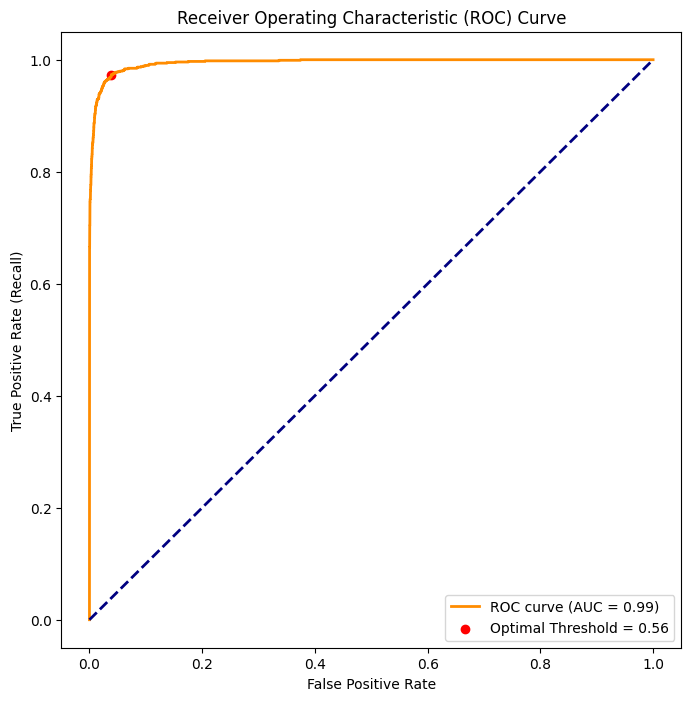

Ïò§Ï∞®ÌñâÎ†¨:
 [[ 955   27]
 [ 394 9757]]

Ï†ïÌôïÎèÑ: 0.9622
Ï†ïÎ∞ÄÎèÑ: 0.7079
Ïû¨ÌòÑÏú®: 0.9725
F1: 0.8194


In [ ]:
# # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÏòàÏ∏° ÌôïÎ•†ÏùÑ ÏñªÏùå
pred_val = model.predict_proba(x_val.fillna(0))[:, 1]

# ROC Í≥°ÏÑ† Í≥ÑÏÇ∞
fpr, tpr, thresholds = roc_curve(y_val, pred_val)

# AUC(Area Under the Curve) Í≥ÑÏÇ∞
roc_auc = auc(fpr, tpr)

# ROC Í≥°ÏÑ† Î∞è AUC Ï∂úÎ†•
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# ROC Í≥°ÏÑ†ÏóêÏÑúÏùò Ï†ÅÏ†àÌïú ÏûÑÍ≥ÑÍ∞í ÏÑ†ÌÉù
optimal_threshold_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_idx]
plt.scatter(fpr[optimal_threshold_idx], tpr[optimal_threshold_idx], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.legend(loc='lower right')

plt.show()

# ÏÑ†ÌÉùÎêú ÏûÑÍ≥ÑÍ∞íÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÏòàÏ∏° ÌÅ¥ÎûòÏä§Î•º ÏñªÏùå
pred = (pred_val > optimal_threshold).astype(int)

get_clf_eval(y_val, pred)

In [ ]:
# threshold = 0.37 >> public score : 0.7541
# ÏµúÏ†ÅÏùò Í∞í : 0.46
threshold = 0.381

In [ ]:
pred_list = []
scores = []
for i,(tri, vai) in enumerate( cv.split(df_train) ):
    pred = models[i].predict_proba(df_train.iloc[vai])[:, 1]
    pred = np.where(pred >= threshold , 1, 0)
    score = f1_score(y_train[vai],pred)
    scores.append(score)
    pred = models[i].predict_proba(df_test)[:, 1]
    pred_list.append(pred)
print(scores)
print(np.mean(scores))

[0.6817138485080338, 0.6443051971986731, 0.631236442516269, 0.6612965093977752, 0.6965092402464065]
0.6630122475734315


In [ ]:
pred = np.mean( pred_list , axis = 0 )
pred = np.where(pred >= threshold , 1, 0)
sum(pred) # TrueÎ°ú ÏòàÏ∏°Îêú Í∞úÏàò

2031

## feature_importance

In [ ]:
model.get_feature_importance(prettified=True)

Feature Id  Importances
0                     customer_idx    28.981948
1                       lead_owner    19.669496
2                    customer_type     7.391744
3               response_corporate     5.980090
4                 lead_desc_length     5.009737
5                     inquiry_type     4.209370
6                 product_category     4.166405
7                          country     3.705954
8             com_reg_ver_win_rate     2.556752
9                    business_unit     2.144901
10                    customer_job     1.993855
11                        business     1.897272
12                   business_area     1.578244
13                            city     1.294997
14               customer_position     1.186325
15               product_modelname     1.076049
16           expected_timeline_num     1.074919
17  historical_existing_cnt_scaled     1.043264
18         historical_existing_cnt     0.966135
19                     bant_submit     0.958303
20                      enterprise     0.896432
21             product_subcategory     0.608423
22                business_subarea     0.590598
23                  ver_win_rate_x     0.560818
24            ver_win_ratio_per_bu     0.457969

# 4. ‚≠ï Ï†úÏ∂úÌïòÍ∏∞

## Ï†úÏ∂ú ÌååÏùº ÏûëÏÑ±

In [ ]:
# # Ï†úÏ∂ú Îç∞Ïù¥ÌÑ∞ ÏùΩÏñ¥Ïò§Í∏∞ (df_testÎäî Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞Í∞Ä Ï†ÄÏû•Îê®)
# df_sub = pd.read_csv("submission.csv")
# df_sub["is_converted"] = pred

# # Ï†úÏ∂ú ÌååÏùº Ï†ÄÏû•
# df_sub.to_csv("submission.csv", index=False)
# print("Ï†úÏ∂ú ÌååÏùº Ï†ÄÏû• ÏôÑÎ£å")

**Ïö∞Ï∏° ÏÉÅÎã®Ïùò Ï†úÏ∂ú Î≤ÑÌäºÏùÑ ÌÅ¥Î¶≠Ìï¥ Í≤∞Í≥ºÎ•º ÌôïÏù∏ÌïòÏÑ∏Ïöî**